Step 1: Generate random scenarios

In [ ]:
import json
import os 
import re
import random
import carla
from agents.navigation.global_route_planner import GlobalRoutePlanner
class ScenarioGenerator:
    def __init__(self, weather, vehicle, traffic, emergency, timeOfDay, location, intersections, pedestrians, pedestrian_cross,route_length, num_scenarios):
        self.weather = weather
        self.vehicle = vehicle
        self.traffic = traffic
        self.emergency = emergency
        self.timeOfDay = timeOfDay
        self.location = location
        self.intersections = intersections
        self.pedestrians = pedestrians
        self.pedestrian_cross = pedestrian_cross
        self.num_scenarios = num_scenarios
        self.route_length = route_length
        
    def generate_scenarios(self):
        

         # Create dictionaries that map each variable value to a difficulty rating
        weather_difficulty = {'Sunny': 1, 'Rain': 5, 'Thunderstorm': 8}
        vehicle_difficulty = {'Small': 1, 'Truck': 2,'Van': 3}
        traffic_difficulty = {'Heavy': 6, 'Light': 1,'Medium': 3}
        emergency_difficulty = {'Yes': 10, 'No': 0}
        timeOfDay_difficulty = {'Day': 1, 'Night':5,'Dawn':2,'Dusk':2}
        location_difficulty = {'Urban':4 , 'Country' :1 ,'Downtown' :3 }
        intersections_difficulty = {0:1 ,1:2 ,2:3 ,3:4 ,4:5 ,5:6 }
        pedestrians_difficulty = {True: 0.5 ,False : 0}
        pedestrian_cross_difficulty = {True : 10, False : 0 }
        route_length_difficulty ={50 :0.5 ,100 :1.5,200 : 2 ,250:2.5,300:3,400:4,500:5,600:6}

        generated_scenarios = []
        directory = 'user_input/NN_run/step1'
        highest_number = 0

        for filename in os.listdir(directory):
            match = re.search(r'random_route_(\d+)', filename)
            if match:
                number = int(match.group(1))
                if number > highest_number:
                    highest_number = number
        

        for i in range(highest_number,self.num_scenarios+highest_number):
            # Randomly choose values for each variable
            weather_choice = random.choice(self.weather)
            vehicle_choice = random.choice(self.vehicle)
            traffic_choice = random.choice(self.traffic)
            emergency_choice= random.choice(self.emergency)
            timeOfDay_choice= random.choice(self.timeOfDay)
            location_choice= random.choice(self.location)
            intersections_choice= random.choice(self.intersections)
            pedestrians_choice= random.choice(self.pedestrians)
            pedestrian_cross_choice= random.choice(self.pedestrian_cross)
            route_length_choice=random.choice(self.route_length)

            
            client = carla.Client("localhost", 2000)
            
            if location_choice == "Downtown":
                world = client.load_world('Town05')
            if location_choice == "Urban":
                world = client.load_world('Town03')
            if location_choice == "Country":
                world = client.load_world('Town07')
            
            map = world.get_map()
            grp = GlobalRoutePlanner(map,2)
 
            waypoints = map.generate_waypoints(2.0)


            def get_route_length(route):
                length = 0
                for i in range(len(route) - 1):
                    length += route[i][0].transform.location.distance(route[i + 1][0].transform.location)
                return length
            
            start_waypoint = 0
            end_waypoint = 0
            for start_waypoint in waypoints:
                for end_waypoint in waypoints:
    
                    route = grp.trace_route(start_waypoint.transform.location, end_waypoint.transform.location)
                    found_route_length = get_route_length(route)
                
                    # Get unique road IDs
                    road_ids = list(set(waypoint[0].road_id for waypoint in route))
                    junction_road_ids = []
                    junctions_on_route = 0
                    if intersections_choice > 0:
                        for road_id in road_ids:
                            # waypoints = map.generate_waypoints(2.0)
                            for waypoint in route:
                                if waypoint[0].road_id == road_id and waypoint[0].is_junction:
                                    junction_road_ids.append(road_id)
                                    # draw_waypoints(waypoints, road_id=road_id, life_time=300)
                        junctions_on_route = len(list(set(junction_road_ids)))

                    if (found_route_length > (route_length_choice-(route_length_choice*0.2)) 
                        and found_route_length < (route_length_choice+(route_length_choice*0.2))
                        and junctions_on_route >= intersections_choice):
                    
                        found = True
                        start_waypoint = start_waypoint.transform.location
                        end_waypoint = end_waypoint.transform.location

                        # Get unique road IDs
                        road_ids = list(set(waypoint[0].road_id for waypoint in route))

                        junction_road_ids = []
                        junctions_on_route = 0
                        for road_id in road_ids:
                            # waypoints = map.generate_waypoints(2.0)
                            for waypoint in route:
                                if waypoint[0].road_id == road_id and waypoint[0].is_junction:
                                    junction_road_ids.append(road_id)
                    
                        junctions_on_route = len(list(set(junction_road_ids)))
                     
                        total_difficulty_rating = (weather_difficulty[weather_choice] +
                            vehicle_difficulty[vehicle_choice] +
                            traffic_difficulty[traffic_choice] +
                            emergency_difficulty[emergency_choice] +
                            timeOfDay_difficulty[timeOfDay_choice] +
                            location_difficulty[location_choice]+
                            (junctions_on_route*5)+
                            pedestrians_difficulty[pedestrians_choice]+
                            pedestrian_cross_difficulty[pedestrian_cross_choice]+
                                    found_route_length)
                        
                       
                        # Create a scenario dictionary with the chosen variable values and total difficulty rating
                        scenario = {
                            'scenario_num': i,
                            'weather': weather_choice,
                            'vehicle': vehicle_choice,
                            'traffic': traffic_choice,
                            'emergency': emergency_choice,
                            'timeOfDay': timeOfDay_choice,
                            'location': location_choice,
                            "intersections": junctions_on_route,
                            "pedestrians": pedestrians_choice,
                            "pedestrian_cross": pedestrian_cross_choice,
                            "start_x": start_waypoint.x,
                            "start_y": start_waypoint.y,
                            "end_x": end_waypoint.x,
                            "end_y": end_waypoint.y,
                            "rounded_route_length": route_length_choice,
                            "route_length": found_route_length,
                            "total_difficulty_rating": total_difficulty_rating
                        }

                        # Create a list of dictionaries representing each location in the route
                        locations = []
                        for waypoint, _ in route:
                            location = waypoint.transform.location
                            locations.append({'X': location.x, 'Y': location.y})

                        # Save the locations to a JSON file
                        with open(f'user_input/NN_run/step1/random_route_{i}.json', 'w') as f:
                            json.dump(locations, f,indent=4)

                        generated_scenarios.append(scenario)
                              
                        with open('user_input/NN_run/step1/random_scenarios.json', 'w') as f:
                            json.dump(generated_scenarios, f, indent=4)

                        break
                        # build path using the route
                if found:
                    break
        
  
        
        return generated_scenarios

weather = ['Sunny', 'Rain', 'Thunderstorm']
vehicle = ['Small', 'Truck','Van']
traffic = ['Heavy', 'Light','Medium']
emergency = ['Yes', 'No']
timeOfDay = ['Day', 'Night','Dawn','Dusk']
location = ['Urban', 'Country','Downtown']
intersections = [0,1,2,3,4]
pedestrians = [True,False]
pedestrian_cross = [True, False]
route_length = [100,150,200,250,300,350,400]
num_scenarios = 70


scenario_generator = ScenarioGenerator(weather, vehicle, traffic, emergency, timeOfDay, location, intersections, pedestrians, pedestrian_cross,route_length, num_scenarios)
random_scenarios = scenario_generator.generate_scenarios()

Step 2: Run random scenarios

In [ ]:
import carla
import json
import os
import re
import time 
from agents.navigation.global_route_planner import GlobalRoutePlanner
import random
import math
from agents.navigation.basic_agent import BasicAgent
from carla import WeatherParameters
import logging
from carla import VehicleLightState as vls

 # Open the JSON file
with open("user_input/NN_run/step1/random_scenarios.json", "r") as file:
    scenario_data = json.load(file)

directory = 'user_input/NN_run/step2'
highest_number = 0

for filename in os.listdir(directory):
    match = re.search(r'auto_scenario_(\d+)', filename)
    if match:
        number = int(match.group(1))
        if number > highest_number:
            highest_number = number

# Initialize variables with the values from the JSON file
def main():
    
    for scenario_num in range(highest_number-2,len(scenario_data)-1):
        try:
           
            weather = scenario_data[scenario_num]["weather"]
            intersections = scenario_data[scenario_num]["intersections"]
            vehicle = scenario_data[scenario_num]["vehicle"]
            traffic = scenario_data[scenario_num]["traffic"]
            emergency = scenario_data[scenario_num]["emergency"]
            timeOfDay = scenario_data[scenario_num]["timeOfDay"]
            location = scenario_data[scenario_num]["location"]
            pedestrians = scenario_data[scenario_num]["pedestrians"]
            pedestrian_cross = scenario_data[scenario_num]["pedestrian_cross"]
            start_x = scenario_data[scenario_num]["start_x"]
            start_y = scenario_data[scenario_num]["start_y"]
            end_x = scenario_data[scenario_num]["end_x"]
            end_y = scenario_data[scenario_num]["end_y"]
            route_length = scenario_data[scenario_num]["route_length"]
            total_difficulty_rating = scenario_data[scenario_num]["total_difficulty_rating"]
            scenario_num = scenario_data[scenario_num]["scenario_num"]


            client = carla.Client("localhost", 2000)

            if location == "Downtown":
                world = client.load_world('Town05')
            if location == "Urban":
                world = client.load_world('Town03')
            if location == "Country":
                world = client.load_world('Town07')

            spectator = world.get_spectator()
            map = world.get_map()

            traffic_manager = client.get_trafficmanager(8000)
            traffic_manager.set_global_distance_to_leading_vehicle(2.5)
            traffic_manager.set_synchronous_mode(True)
            traffic_manager.global_percentage_speed_difference(50.0)


            cloudiness=0.0,
            precipitation=0.0,
            sun_altitude_angle=70.0  # 70 degrees is around noon

            # Set the weather conditions
            if weather == "Sunny":
                cloudiness=10
                precipitation=0.0
                precipitation_deposits=0

            elif weather == "Rain":
                cloudiness=80
                precipitation=60.0
                precipitation_deposits=30
                
            elif weather == "Thunderstorm":
                cloudiness=100
                precipitation=90.0
                precipitation_deposits=60
                

            if timeOfDay == "Day":
                sun_altitude_angle=70.0
            elif timeOfDay == "Night":
                sun_altitude_angle=-30.0
            elif timeOfDay == "Dawn":
                sun_altitude_angle=20.0
            elif timeOfDay == "Dusk":
                sun_altitude_angle=110.0

            weather_params = WeatherParameters(
                cloudiness=cloudiness,
                precipitation=precipitation,
                sun_altitude_angle=sun_altitude_angle,  
                precipitation_deposits=precipitation_deposits 
            )

            # Set the weather in the simulation
            world.set_weather(weather_params)

    
            grp = GlobalRoutePlanner(map,2)

            spawn_points = map.get_spawn_points()

            # Set the desired number of junctions
            num_junctions = intersections

            waypoints = map.generate_waypoints(2.0)

            def draw_waypoints(waypoints, road_id=None, life_time=50.0):
                spawned = False 
                for waypoint in waypoints:
                    
                    if(waypoint.road_id == road_id):
                        world.debug.draw_string(waypoint.transform.location, "JUNC", draw_shadow=False,
                                                color=carla.Color(r=0, g=255, b=0), life_time=life_time,
                                                persistent_lines=True)

            def get_route_length(route):
                length = 0
                for i in range(len(route) - 1):
                    length += route[i][0].transform.location.distance(route[i + 1][0].transform.location)
                return length
            
            start_location = carla.Location(x=start_x,y=start_y)
            end_location = carla.Location(x=end_x,y=end_y)
            
            # print(start_waypoint.transform.location.distance(end_waypoint.transform.location))
            route = grp.trace_route(start_location,end_location)
        
                    
            # The 'waypoints' variable now contains a list of waypoints that define a route between 'start_pose' and 'end_pose' that goes through 'num_junctions' junctions.

            i = 0
            for w in route:
                if i % 10 == 0:
                    world.debug.draw_string(w[0].transform.location, 'O', draw_shadow=False,
                    color=carla.Color(r=255, g=0, b=0), life_time=1000.0,
                    persistent_lines=True)
                else:
                    world.debug.draw_string(w[0].transform.location, 'O', draw_shadow=False,
                    color = carla.Color(r=0, g=0, b=255), life_time=1000.0,
                    persistent_lines=True)
                i += 1

            vehicles_list = []
            walkers_list = []
            all_id = []

            def spawn_random_pedestrians_and_cars(world, route):
                # Get the blueprint library
                blueprint_library = world.get_blueprint_library()

                # Get the pedestrian and car blueprints
                pedestrian_blueprints = blueprint_library.filter("walker.pedestrian.*")
                car_blueprints = blueprint_library.filter("vehicle.*")

                # Set the number of pedestrians and cars to spawn
                num_pedestrians = 0
                num_cars = 10

                # Spawn pedestrians along the route
                for i in range(num_pedestrians):
                    # Choose a random waypoint along the route
                    waypoint = random.choice(route)[0]

                    # Choose a random pedestrian blueprint
                    pedestrian_bp = random.choice(pedestrian_blueprints)

                    # Spawn the pedestrian at the waypoint location
                    world.try_spawn_actor(pedestrian_bp, waypoint.transform)

                # Spawn cars along the route
                for i in range(num_cars):
                    # Choose a random waypoint along the route
                    waypoint = random.choice(route)[0]

                    # Choose a random car blueprint
                    car_bp = random.choice(car_blueprints)

                    # Spawn the car at the waypoint location with some offset in z-axis to prevent collision with ground.
                    transform = carla.Transform(waypoint.transform.location + carla.Location(z=0.5),waypoint.transform.rotation)
                    
                    vehicle_actor = world.try_spawn_actor(car_bp, transform)
                    
                    if vehicle_actor:
                        # Set the vehicle to autopilot
                        vehicles_list.append(vehicle_actor)
                        vehicle_actor.set_autopilot(True)

            def get_first_last_location(route):
                first_location = route[0][0].transform.location
                last_location = route[-1][0].transform.location
                return first_location, last_location

            
            first_location, last_location = get_first_last_location(route)

            # Spawn a vehicle and set it to drive to destination
            blueprint_library = world.get_blueprint_library()
            pedestrian_bps = blueprint_library.filter("walker.pedestrian.*")

            if vehicle == "Small":
                vehicle_bp = blueprint_library.filter("a2")[0]
            elif vehicle == "Truck":
                vehicle_bp = blueprint_library.filter("cybertruck")[0]
            elif vehicle == "Van":
                vehicle_bp = blueprint_library.filter("carlacola")[0]
                 
            vehicle_actor = world.spawn_actor(vehicle_bp, carla.Transform(first_location+carla.Location(z=0.5)))
            
            vehicles_list.append(vehicle_actor)

            vehicle_ids = []
            if traffic == "Light" or traffic == "Heavy" or traffic == "Medium": 
                
                filtered_spawn_points = []

                # Get unique road IDs
                road_ids = list(set(waypoint[0].road_id for waypoint in route))
              
                for road_id in road_ids:
                    # waypoints = map.generate_waypoints(2.0)
                    for point in spawn_points:
                        if map.get_waypoint(point.location).road_id == road_id:
                            filtered_spawn_points.append(point)
                       
                number_of_spawn_points = len(filtered_spawn_points)

                if traffic == "Light":
                    num_cars = 15
                elif traffic == "Medium":
                    num_cars = 25
                elif traffic == "Heavy":
                    num_cars = 40
                
                SpawnActor = carla.command.SpawnActor
                SetAutopilot = carla.command.SetAutopilot
                SetVehicleLightState = carla.command.SetVehicleLightState
                FutureActor = carla.command.FutureActor

                blueprints = world.get_blueprint_library().filter('vehicle.*')
                blueprints = sorted(blueprints, key=lambda bp: bp.id)

                if num_cars < number_of_spawn_points:
                    random.shuffle(filtered_spawn_points)
                elif num_cars > number_of_spawn_points:
                    msg = 'requested %d vehicles, but could only find %d spawn points'
                    logging.warning(msg, num_cars, number_of_spawn_points)
                    num_cars = number_of_spawn_points


                batch = []
                for n, transform in enumerate(filtered_spawn_points):
                    # print(transform)
                    if n >= num_cars:
                        break
                    blueprint = random.choice(blueprints) 
                    if blueprint.has_attribute('color'):
                        color = random.choice(blueprint.get_attribute('color').recommended_values)
                        blueprint.set_attribute('color', color)
                    if blueprint.has_attribute('driver_id'):
                        driver_id = random.choice(blueprint.get_attribute('driver_id').recommended_values)
                        blueprint.set_attribute('driver_id', driver_id)

                
                    blueprint.set_attribute('role_name', 'autopilot')

                    # prepare the light state of the cars to spawn
                    light_state = vls.NONE
                    if True:
                        light_state = vls.Position | vls.LowBeam | vls.LowBeam

                    # spawn the cars and set their autopilot and light state all together
                    batch.append(SpawnActor(blueprint, transform)
                        .then(SetAutopilot(FutureActor, True, traffic_manager.get_port()))
                        .then(SetVehicleLightState(FutureActor, light_state)))

                spawn_random_pedestrians_and_cars(world,route)  
                    
                for response in client.apply_batch_sync(batch, True):
                    if response.error:
                        logging.error(response.error)
                    else:
                        vehicle_ids.append(response.actor_id)

            if pedestrians == True:
                if emergency == "No":
                    percentagePedestriansRunning = 20     # how many pedestrians will run
                    percentagePedestriansCrossing = 30     # how many pedestrians will walk through the road
                else:
                    percentagePedestriansRunning = 80
                    percentagePedestriansCrossing = 70
                
                # 1. take all the random locations to spawn
                spawn_points = []
                for i in range(30):
                    spawn_point = carla.Transform()
                    loc = world.get_random_location_from_navigation()
                    if (loc != None):
                        spawn_point.location = loc
                        spawn_points.append(spawn_point)
                # 2. we spawn the walker object
                batch = []
                walker_speed = []
                for spawn_point in spawn_points:
                    walker_bp = random.choice(pedestrian_bps)
                    # set as not invincible
                    if walker_bp.has_attribute('is_invincible'):
                        walker_bp.set_attribute('is_invincible', 'false')
                    # set the max speed
                    if walker_bp.has_attribute('speed'):
                        if (random.random() > percentagePedestriansRunning):
                            # walking
                            walker_speed.append(walker_bp.get_attribute('speed').recommended_values[1])
                        else:
                            # running
                            walker_speed.append(walker_bp.get_attribute('speed').recommended_values[2])
                    else:
                        print("Walker has no speed")
                        walker_speed.append(0.0)
                    batch.append(SpawnActor(walker_bp, spawn_point))
                results = client.apply_batch_sync(batch, True)
                walker_speed2 = []
                for i in range(len(results)):
                    if results[i].error:
                        logging.error(results[i].error)
                    else:
                        walkers_list.append({"id": results[i].actor_id})
                        walker_speed2.append(walker_speed[i])
                walker_speed = walker_speed2
                # 3. we spawn the walker controller
                batch = []
                walker_controller_bp = world.get_blueprint_library().find('controller.ai.walker')
                for i in range(len(walkers_list)):
                    batch.append(SpawnActor(walker_controller_bp, carla.Transform(), walkers_list[i]["id"]))
                results = client.apply_batch_sync(batch, True)
                for i in range(len(results)):
                    if results[i].error:
                        logging.error(results[i].error)
                    else:
                        walkers_list[i]["con"] = results[i].actor_id
                # 4. we put together the walkers and controllers id to get the objects from their id
                for i in range(len(walkers_list)):
                    all_id.append(walkers_list[i]["con"])
                    all_id.append(walkers_list[i]["id"])
                all_actors = world.get_actors(all_id)

                # 5. initialize each controller and set target to walk to (list is [controler, actor, controller, actor ...])
                # set how many pedestrians can cross the road
                world.set_pedestrians_cross_factor(percentagePedestriansCrossing)
                for i in range(0, len(all_id), 2):
                    # start walker
                    all_actors[i].start()
                    # set walk to random point
                    all_actors[i].go_to_location(world.get_random_location_from_navigation())
                    # max speed
                    all_actors[i].set_max_speed(float(walker_speed[int(i/2)]))

               
            print('spawned %d vehicles and %d walkers, press Ctrl+C to exit.' % (len(vehicle_ids)+len(vehicles_list), len(walkers_list)))         

            for vehicle in vehicles_list:

                vehicle_physics_control = vehicle.get_physics_control()

                if weather == "Rain":
                    # Create Wheels Physics Control
                        
                    front_left_wheel = carla.WheelPhysicsControl(tire_friction=0.9,max_steer_angle=70)
                    front_right_wheel = carla.WheelPhysicsControl(tire_friction=0.9,max_steer_angle=70)
                    rear_left_wheel = carla.WheelPhysicsControl(tire_friction=0.9,max_steer_angle=0)
                    rear_right_wheel = carla.WheelPhysicsControl(tire_friction=0.9,max_steer_angle=0)
                    wheels = [front_left_wheel, front_right_wheel, rear_left_wheel, rear_right_wheel]
                    vehicle_physics_control.wheels = wheels 
                    vehicle.apply_physics_control(vehicle_physics_control)

                    print("Changed grip to Rain")

                if weather == "Thunderstorm":
                    front_left_wheel = carla.WheelPhysicsControl(tire_friction=0.75,max_steer_angle=70)
                    front_right_wheel = carla.WheelPhysicsControl(tire_friction=0.75,max_steer_angle=70)
                    rear_left_wheel = carla.WheelPhysicsControl(tire_friction=0.75,max_steer_angle=0)
                    rear_right_wheel = carla.WheelPhysicsControl(tire_friction=0.75,max_steer_angle=0)
                    wheels = [front_left_wheel, front_right_wheel, rear_left_wheel, rear_right_wheel]
                    vehicle_physics_control.wheels = wheels 
                    vehicle.apply_physics_control(vehicle_physics_control)
                    print("Changed grip Thunder")

    
            agent = BasicAgent(vehicle_actor)

            # Set the destination
            location = first_location 

            agent.set_global_plan(route,stop_waypoint_creation=True, clean_queue=True)
            

            sensors = []

            collision_bp = world.get_blueprint_library().find('sensor.other.collision')
            collision_transform = carla.Transform(carla.Location(x=1.5, z=2.4))
            collision_sensor = world.spawn_actor(collision_bp, collision_transform, attach_to=vehicle_actor)

            collision_count = {}
            max_collisions = 1500
            collided_actors = set()

            def on_collision(event):
                other_actor = event.other_actor
                if other_actor not in collided_actors:
                    collided_actors.add(other_actor)
                    print(other_actor)
                    if other_actor.type_id not in collision_count:
                        collision_count[other_actor.type_id] = 0
                    collision_count[other_actor.type_id] += 1
                    # print(f"Collision with {other_actor.type_id} - Count: {collision_count[other_actor.type_id]}")
                    

            collision_sensor.listen(on_collision)

            # Get the blueprint for the lane invasion sensor
            lane_invasion_bp = world.get_blueprint_library().find('sensor.other.lane_invasion')

            # Create a transform object to specify the location and rotation of the sensor relative to the vehicle
            lane_invasion_transform = carla.Transform()

            # Spawn the lane invasion sensor actor and attach it to the vehicle
            lane_invasion_sensor = world.spawn_actor(lane_invasion_bp, lane_invasion_transform, attach_to=vehicle_actor)

            lane_cross_counter = {}

            def on_lane_invasion(event):
                for marking in event.crossed_lane_markings:
                    if marking.type == carla.LaneMarkingType.Solid or marking.type == carla.LaneMarkingType.SolidSolid:
                        if marking.type not in lane_cross_counter:
                            lane_cross_counter[marking.type] = 0
                        lane_cross_counter[marking.type] += 1
                        # print(f"Crossed: {marking.type} - Count: {lane_cross_counter[marking.type]}")

            lane_invasion_sensor.listen(on_lane_invasion)

            sensors.append(collision_sensor)
            sensors.append(lane_invasion_sensor)


            def print_vehicle_info(vehicle):
                    print("Game time: ", world.get_snapshot().timestamp.elapsed_seconds)
                    print("Vehicle location: ", vehicle.get_location())
                    print("Vehicle velocity: ", vehicle.get_velocity())
                    print("Vehicle throttle: ", vehicle.get_control().throttle)

            def save_vehicle_info(vehicle, file_path, collision_count, lane_cross_counter):
                # Check if file exists, create it if it doesn't
                if not os.path.exists(file_path):
                    with open(file_path, 'w') as f:
                        json.dump([], f)

                # Load existing data from file
                with open(file_path, 'r') as f:
                    data = json.load(f)

                # Add new data
                new_data = {
                    'game_time': world.get_snapshot().timestamp.elapsed_seconds,
                    'vehicle_location': {'x': vehicle.get_location().x, 'y': vehicle.get_location().y, 'z': vehicle.get_location().z},
                    'vehicle_velocity': {'x': vehicle.get_velocity().x, 'y': vehicle.get_velocity().y, 'z': vehicle.get_velocity().z},
                    'vehicle_throttle': vehicle.get_control().throttle,
                    'unique_collisions': len(collision_count),
                    'solid_lane_crosses': lane_cross_counter.get(carla.LaneMarkingType.Solid, 0),
                    'double_solid_lane_crosses': lane_cross_counter.get(carla.LaneMarkingType.SolidSolid, 0)
                }

                data.append(new_data)

                # Save data to file
                with open(file_path, 'w') as f:
                    json.dump(data, f, indent=4)


            file_path = f'user_input/NN_run/step2/auto_scenario_{scenario_num}.json'

            with open(file_path, 'w') as f:
                        json.dump([], f)

            info_time = world.get_snapshot().timestamp.elapsed_seconds
            while True:

                
                actor = vehicle_actor
                actor_location = actor.get_location()
                actor_transform = actor.get_transform()
                actor_yaw = actor_transform.rotation.yaw
                spectator.set_transform(carla.Transform(actor_location+carla.Location(  z=10, 
                                                                      
                                                                                        x= - 10*math.cos(math.radians(actor_yaw)), 
                                                                                        y= - 10*math.sin(math.radians(actor_yaw))),
                
                                                                                         carla.Rotation(pitch= -30 ,yaw=actor_yaw)))
                world.tick()
                
                if any(count > max_collisions for count in collision_count.values()):
                    print('Vehicle stuck detected, stopping scenario')
                    break

                if agent.done():
                    break

                if world.get_snapshot().timestamp.elapsed_seconds - info_time >= 1:
                       
                        save_vehicle_info(vehicle_actor, file_path,collision_count,lane_cross_counter)
                        # print_vehicle_info(vehicle)
                        info_time = world.get_snapshot().timestamp.elapsed_seconds

                control = agent.run_step()
                vehicle_actor.apply_control(control)
                
        finally:

            # Clean up the actors
            # print('\ndestroying %d vehicles' % (len(vehicle_ids)+len(vehicles_list)))
            client.apply_batch([carla.command.DestroyActor(x) for x in vehicle_ids])
            client.apply_batch([carla.command.DestroyActor(x) for x in vehicles_list])
            
            # stop walker controllers (list is [controller, actor, controller, actor ...])
            for i in range(0, len(all_id), 2):
                all_actors[i].stop()

            for i in range(len(sensors)-1):
                sensors[i].destroy()

            # print('\ndestroying %d walkers' % len(walkers_list))
            client.apply_batch([carla.command.DestroyActor(x) for x in all_id])
            time.sleep(0.5)

if __name__ == '__main__':

    try:
        main()
    except KeyboardInterrupt:
        pass
    finally:
        print('\ndone.')
    

Step 3: Rate actor performance in these scenarios

21


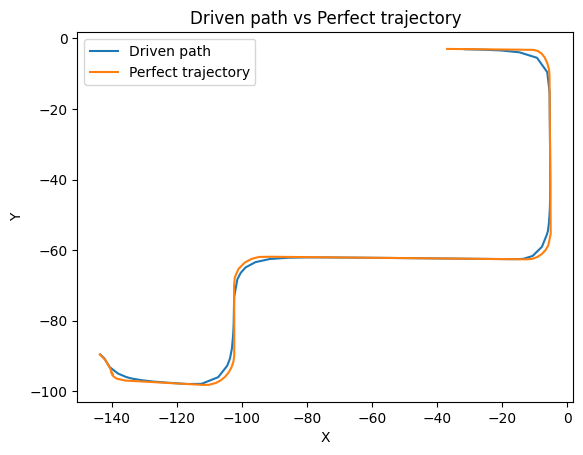

Average velocity: 0.57 m/s
Average acceleration: -0.03 m/s^2
Max acceleration: 1.56 m/s^2
Driven path length: 242.78 meters
Ideal trajectory length: 258.06 meters
DTW: 278.4096830398128
Calculated score: 36.05
There are 68 generated scenarios
24


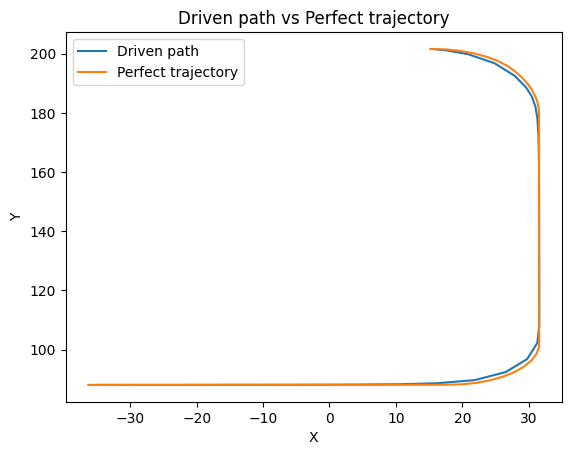

Average velocity: -0.57 m/s
Average acceleration: -0.06 m/s^2
Max acceleration: 1.52 m/s^2
Driven path length: 180.09 meters
Ideal trajectory length: 184.16 meters
DTW: 142.25738151998274
Calculated score: 858.38
There are 68 generated scenarios
65


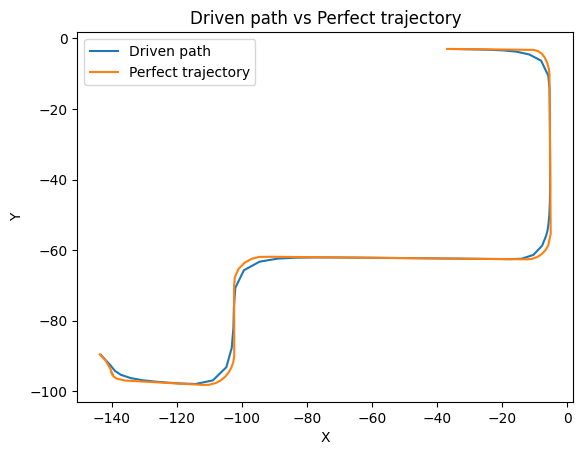

Average velocity: 0.80 m/s
Average acceleration: -0.02 m/s^2
Max acceleration: 2.71 m/s^2
Driven path length: 245.72 meters
Ideal trajectory length: 258.06 meters
DTW: 224.02318762724175
Calculated score: 775.19
There are 68 generated scenarios
38


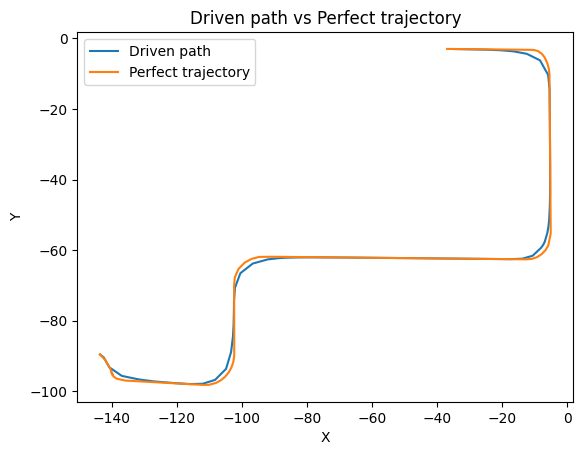

Average velocity: 0.77 m/s
Average acceleration: -0.00 m/s^2
Max acceleration: 1.97 m/s^2
Driven path length: 246.22 meters
Ideal trajectory length: 258.06 meters
DTW: 210.59317758904578
Calculated score: 788.64
There are 68 generated scenarios
66


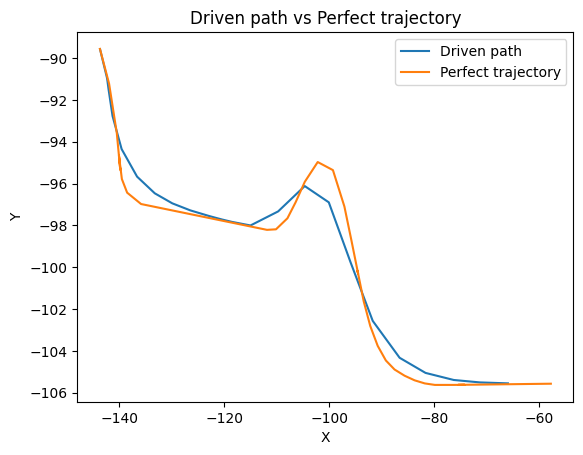

Average velocity: 2.72 m/s
Average acceleration: 0.18 m/s^2
Max acceleration: 1.99 m/s^2
Driven path length: 82.71 meters
Ideal trajectory length: 98.35 meters
DTW: 93.47356626095768
Calculated score: 45.18
There are 68 generated scenarios
13


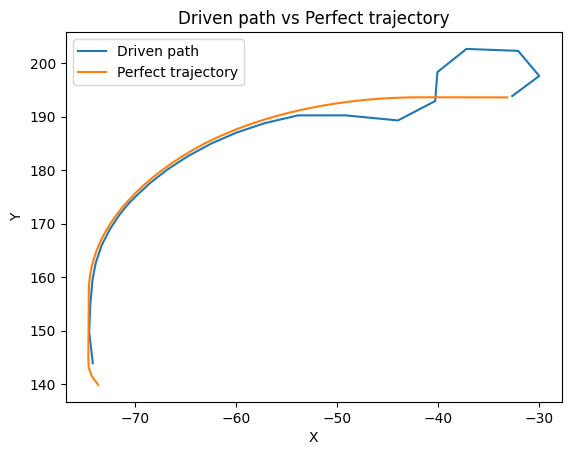

Average velocity: -0.80 m/s
Average acceleration: -0.04 m/s^2
Max acceleration: 2.26 m/s^2
Driven path length: 95.17 meters
Ideal trajectory length: 80.58 meters
DTW: 103.83062923276255
Calculated score: 897.00
There are 68 generated scenarios
40


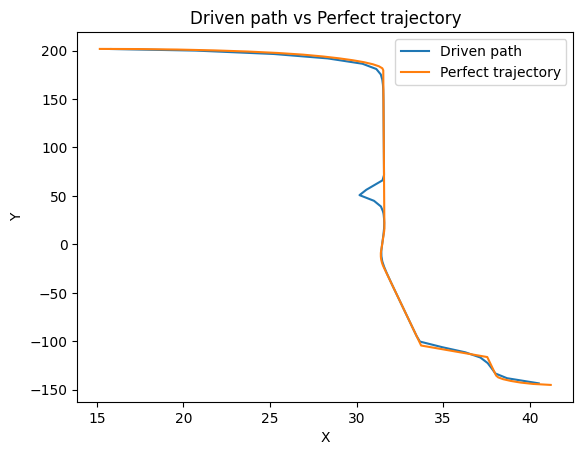

Average velocity: 0.16 m/s
Average acceleration: -0.00 m/s^2
Max acceleration: 1.49 m/s^2
Driven path length: 353.01 meters
Ideal trajectory length: 356.73 meters
DTW: 342.76454551109873
Calculated score: 32.85
There are 68 generated scenarios
42


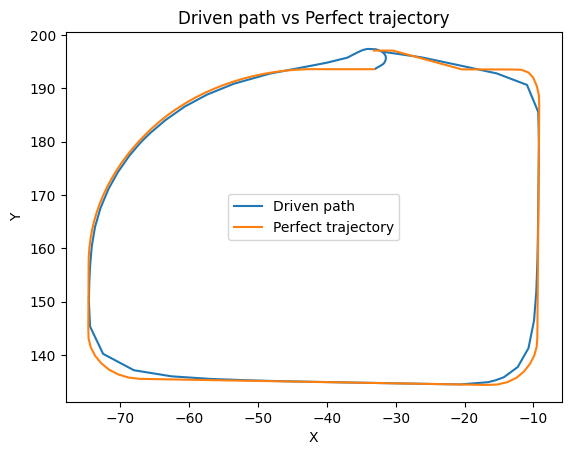

Average velocity: -0.01 m/s
Average acceleration: -0.04 m/s^2
Max acceleration: 2.20 m/s^2
Driven path length: 223.65 meters
Ideal trajectory length: 230.24 meters
DTW: 277.3605395413202
Calculated score: 70.46
There are 68 generated scenarios
45


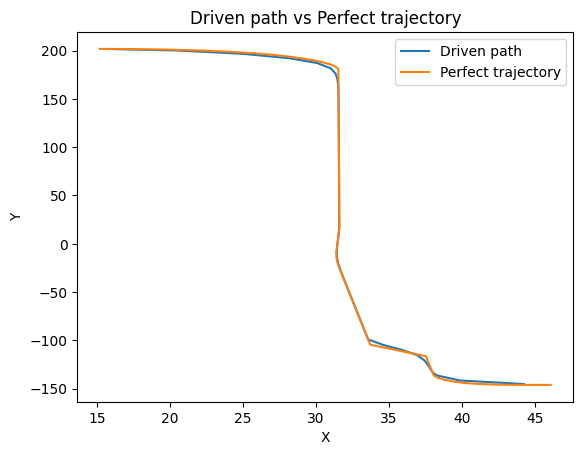

Average velocity: 0.14 m/s
Average acceleration: 0.02 m/s^2
Max acceleration: 2.23 m/s^2
Driven path length: 356.47 meters
Ideal trajectory length: 361.80 meters
DTW: 315.2947661244188
Calculated score: 684.55
There are 68 generated scenarios
15


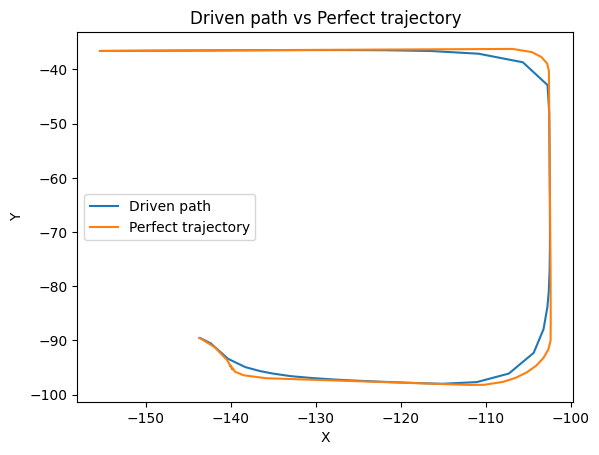

Average velocity: -0.29 m/s
Average acceleration: -0.09 m/s^2
Max acceleration: 1.64 m/s^2
Driven path length: 148.77 meters
Ideal trajectory length: 155.83 meters
DTW: 126.42174484959901
Calculated score: 873.96
There are 68 generated scenarios
16


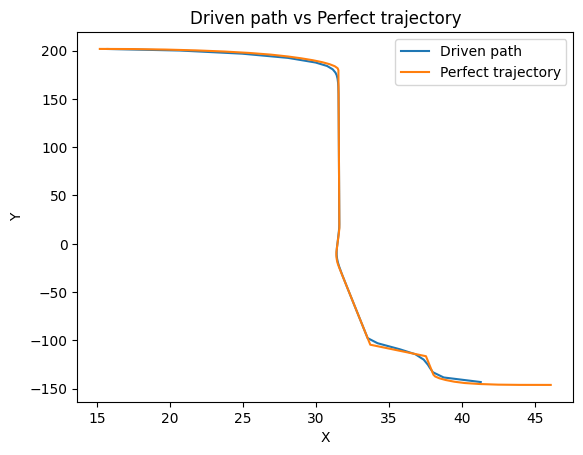

Average velocity: 0.13 m/s
Average acceleration: 0.02 m/s^2
Max acceleration: 2.87 m/s^2
Driven path length: 352.91 meters
Ideal trajectory length: 361.80 meters
DTW: 265.0694461234803
Calculated score: 734.78
There are 68 generated scenarios
53


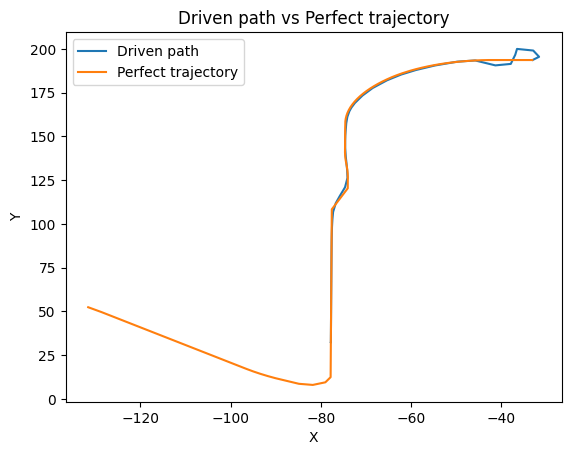

Average velocity: -0.43 m/s
Average acceleration: -0.01 m/s^2
Max acceleration: 2.36 m/s^2
Driven path length: 202.34 meters
Ideal trajectory length: 281.90 meters
DTW: 1495.7233249054957
Calculated score: -24.76
There are 68 generated scenarios
43


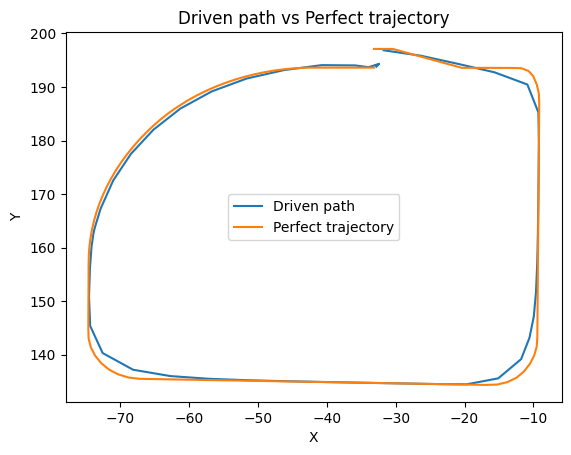

Average velocity: -0.02 m/s
Average acceleration: -0.08 m/s^2
Max acceleration: 2.23 m/s^2
Driven path length: 218.60 meters
Ideal trajectory length: 230.24 meters
DTW: 207.45897460675417
Calculated score: 39.63
There are 68 generated scenarios
27


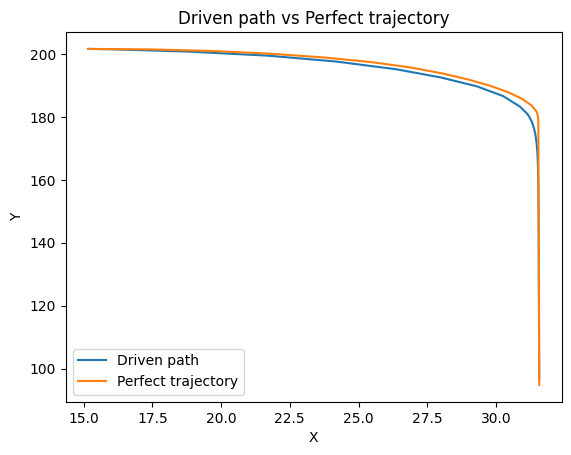

Average velocity: 0.12 m/s
Average acceleration: 0.01 m/s^2
Max acceleration: 2.91 m/s^2
Driven path length: 112.86 meters
Ideal trajectory length: 115.48 meters
DTW: 79.24699534213006
Calculated score: 920.62
There are 68 generated scenarios
41


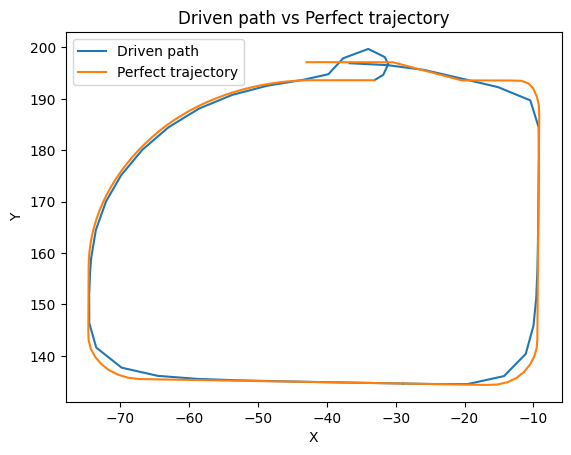

Average velocity: -0.07 m/s
Average acceleration: -0.05 m/s^2
Max acceleration: 2.15 m/s^2
Driven path length: 231.60 meters
Ideal trajectory length: 240.05 meters
DTW: 244.8995369403811
Calculated score: 37.76
There are 68 generated scenarios
39


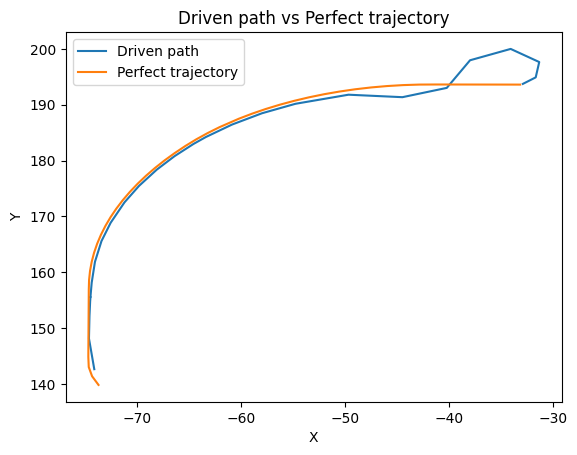

Average velocity: -0.91 m/s
Average acceleration: 0.01 m/s^2
Max acceleration: 0.89 m/s^2
Driven path length: 88.01 meters
Ideal trajectory length: 80.58 meters
DTW: 86.99067625948744
Calculated score: 913.91
There are 68 generated scenarios
50


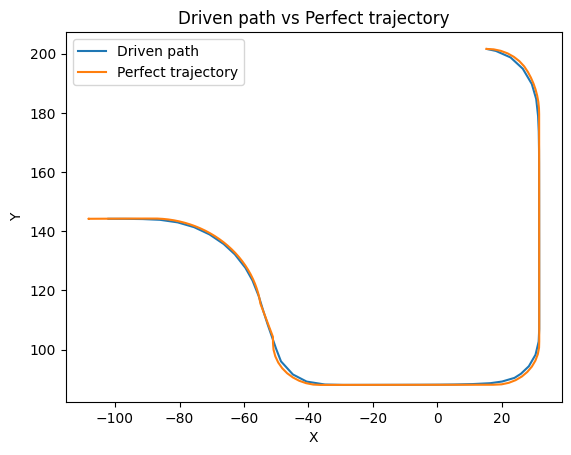

Average velocity: -1.05 m/s
Average acceleration: -0.05 m/s^2
Max acceleration: 1.90 m/s^2
Driven path length: 278.71 meters
Ideal trajectory length: 288.96 meters
DTW: 225.9555997105182
Calculated score: 775.14
There are 68 generated scenarios
10


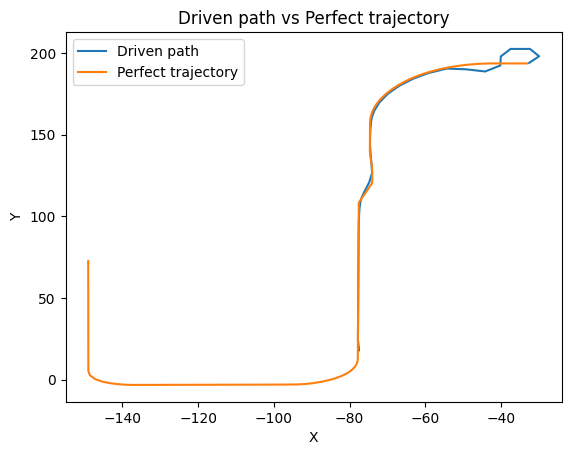

Average velocity: -0.44 m/s
Average acceleration: -0.03 m/s^2
Max acceleration: 2.44 m/s^2
Driven path length: 222.42 meters
Ideal trajectory length: 359.93 meters
DTW: 4561.682155114957
Calculated score: -347.22
There are 68 generated scenarios
1


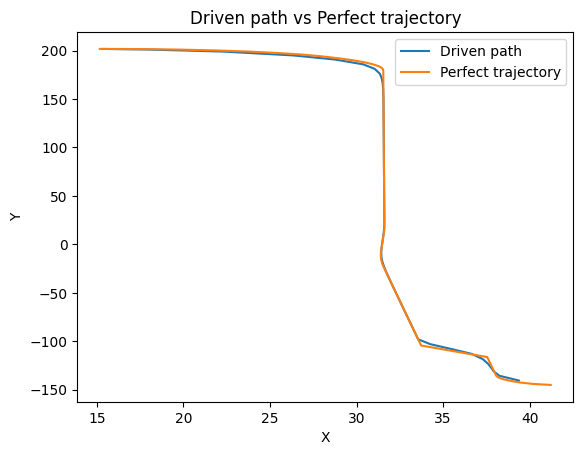

Average velocity: 0.11 m/s
Average acceleration: 0.01 m/s^2
Max acceleration: 2.08 m/s^2
Driven path length: 350.13 meters
Ideal trajectory length: 356.73 meters
DTW: 287.1617100125977
Calculated score: 712.72
There are 68 generated scenarios
30


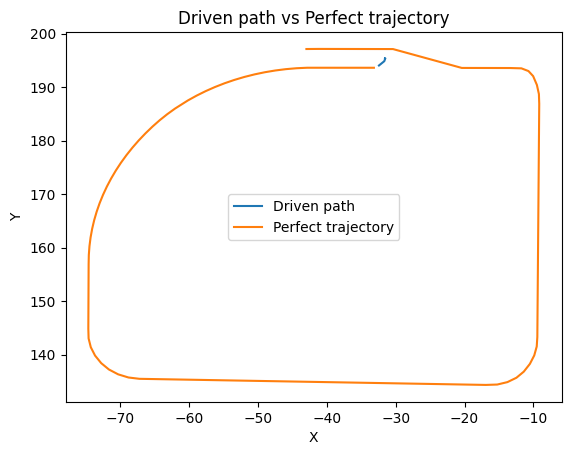

Average velocity: 0.17 m/s
Average acceleration: -0.24 m/s^2
Max acceleration: 0.01 m/s^2
Driven path length: 1.69 meters
Ideal trajectory length: 240.05 meters
DTW: 5553.737191149781
Calculated score: -227.68
There are 68 generated scenarios
60


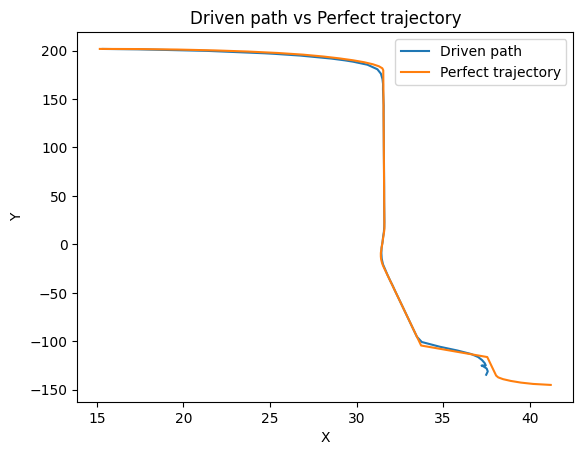

Average velocity: 0.08 m/s
Average acceleration: 0.00 m/s^2
Max acceleration: 2.11 m/s^2
Driven path length: 344.43 meters
Ideal trajectory length: 356.73 meters
DTW: 358.4565548540709
Calculated score: 32.07
There are 68 generated scenarios
22


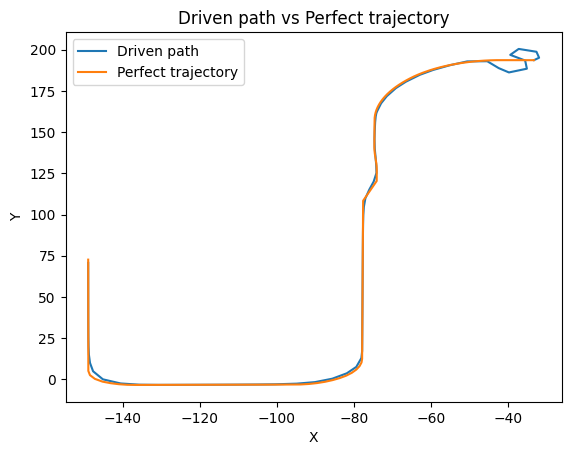

Average velocity: -1.06 m/s
Average acceleration: -0.00 m/s^2
Max acceleration: 3.38 m/s^2
Driven path length: 381.49 meters
Ideal trajectory length: 359.93 meters
DTW: 297.2951384442918
Calculated score: 703.76
There are 68 generated scenarios
62


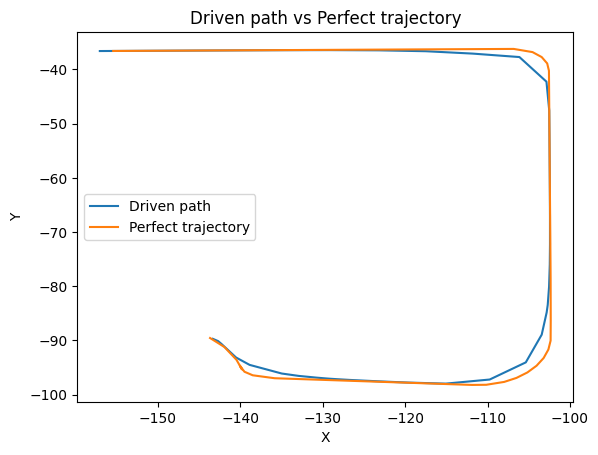

Average velocity: -0.27 m/s
Average acceleration: -0.11 m/s^2
Max acceleration: 2.69 m/s^2
Driven path length: 150.45 meters
Ideal trajectory length: 155.83 meters
DTW: 130.473728000034
Calculated score: 43.50
There are 68 generated scenarios
3


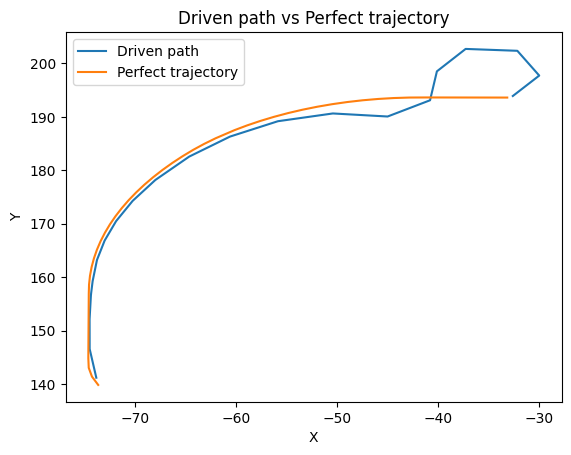

Average velocity: -1.00 m/s
Average acceleration: -0.05 m/s^2
Max acceleration: 2.24 m/s^2
Driven path length: 96.50 meters
Ideal trajectory length: 80.58 meters
DTW: 104.54465626584032
Calculated score: 896.51
There are 68 generated scenarios
5


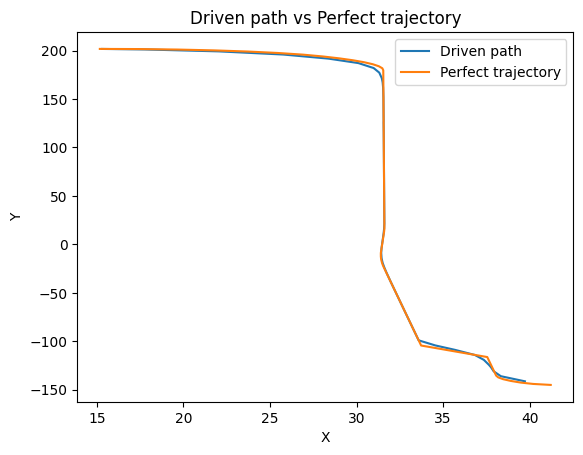

Average velocity: 0.12 m/s
Average acceleration: 0.01 m/s^2
Max acceleration: 2.14 m/s^2
Driven path length: 351.12 meters
Ideal trajectory length: 356.73 meters
DTW: 275.637889552449
Calculated score: 724.23
There are 68 generated scenarios
49


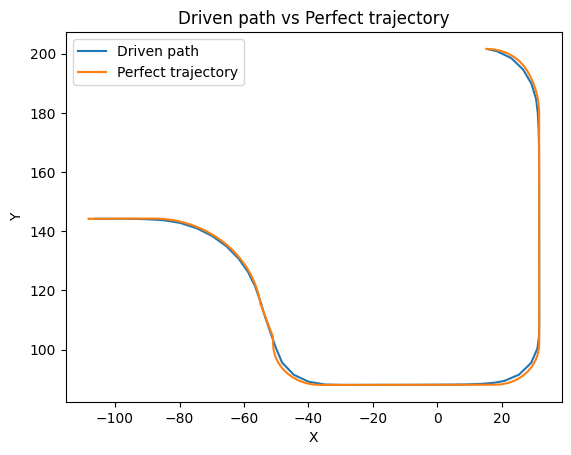

Average velocity: -0.84 m/s
Average acceleration: -0.04 m/s^2
Max acceleration: 2.48 m/s^2
Driven path length: 282.61 meters
Ideal trajectory length: 288.96 meters
DTW: 213.93322501573743
Calculated score: 786.94
There are 68 generated scenarios
63


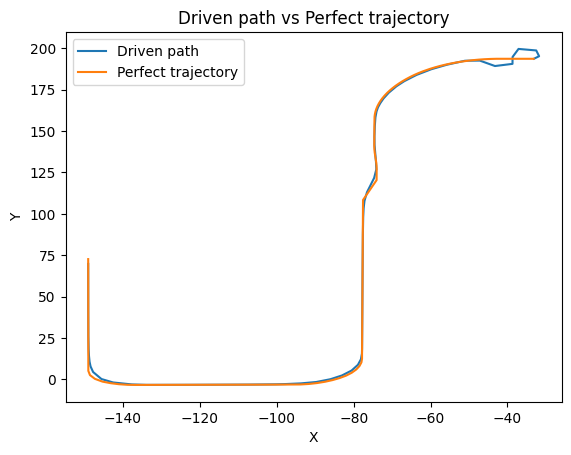

Average velocity: -0.75 m/s
Average acceleration: -0.00 m/s^2
Max acceleration: 2.61 m/s^2
Driven path length: 369.21 meters
Ideal trajectory length: 359.93 meters
DTW: 246.26252376972576
Calculated score: 754.49
There are 68 generated scenarios
35


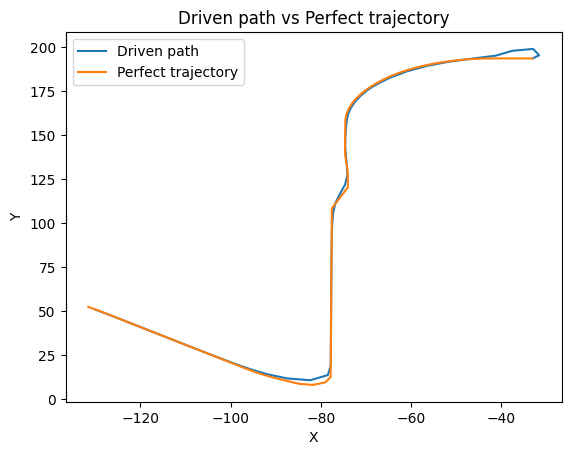

Average velocity: -0.99 m/s
Average acceleration: -0.05 m/s^2
Max acceleration: 1.52 m/s^2
Driven path length: 282.13 meters
Ideal trajectory length: 281.90 meters
DTW: 215.69355440342204
Calculated score: 785.35
There are 68 generated scenarios
64


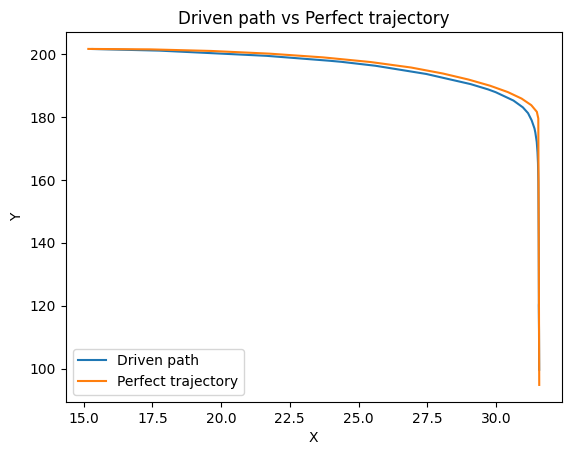

Average velocity: 0.08 m/s
Average acceleration: -0.00 m/s^2
Max acceleration: 2.06 m/s^2
Driven path length: 109.71 meters
Ideal trajectory length: 115.48 meters
DTW: 128.40861506124583
Calculated score: 871.52
There are 68 generated scenarios
12


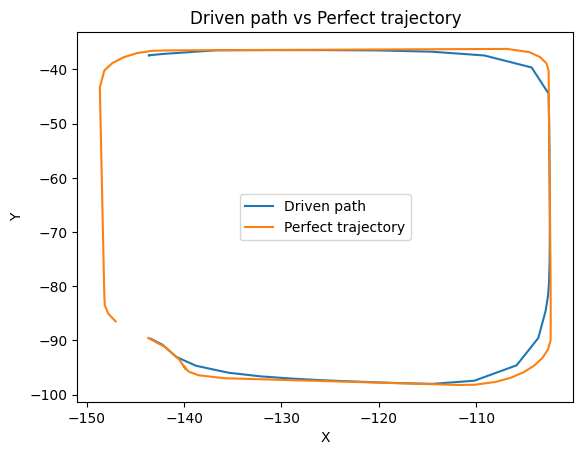

Average velocity: -0.04 m/s
Average acceleration: -0.01 m/s^2
Max acceleration: 2.67 m/s^2
Driven path length: 136.90 meters
Ideal trajectory length: 196.59 meters
DTW: 832.9530170004668
Calculated score: 8.35
There are 68 generated scenarios
68


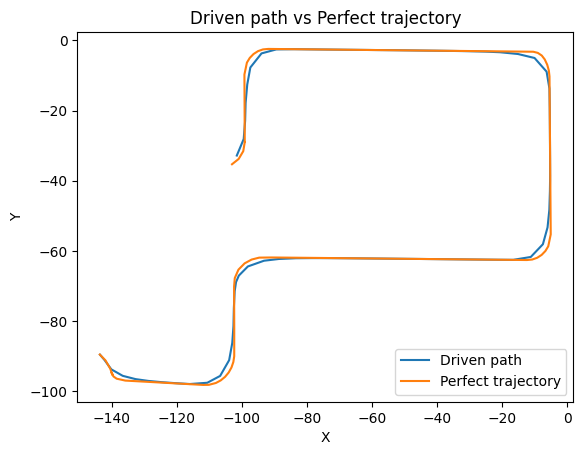

Average velocity: 0.41 m/s
Average acceleration: -0.04 m/s^2
Max acceleration: 1.93 m/s^2
Driven path length: 336.23 meters
Ideal trajectory length: 351.66 meters
DTW: 271.0093144841098
Calculated score: 728.62
There are 68 generated scenarios
58


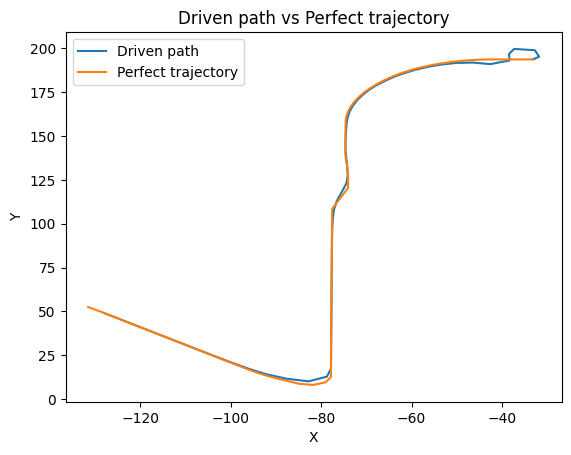

Average velocity: -0.66 m/s
Average acceleration: -0.02 m/s^2
Max acceleration: 2.74 m/s^2
Driven path length: 284.81 meters
Ideal trajectory length: 281.90 meters
DTW: 230.75369836736616
Calculated score: 769.93
There are 68 generated scenarios
61


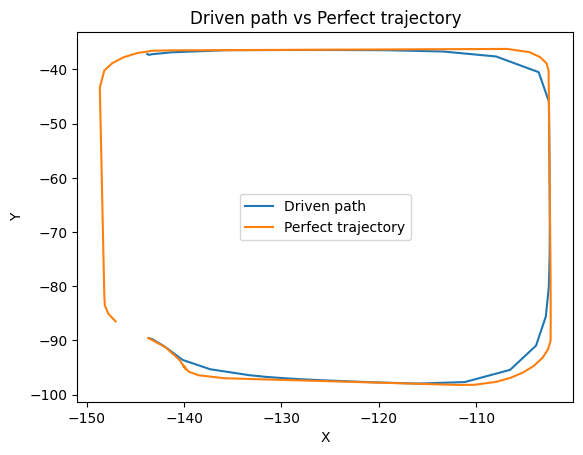

Average velocity: -0.07 m/s
Average acceleration: 0.01 m/s^2
Max acceleration: 2.51 m/s^2
Driven path length: 137.40 meters
Ideal trajectory length: 196.59 meters
DTW: 846.4282482566305
Calculated score: 7.68
There are 68 generated scenarios
37


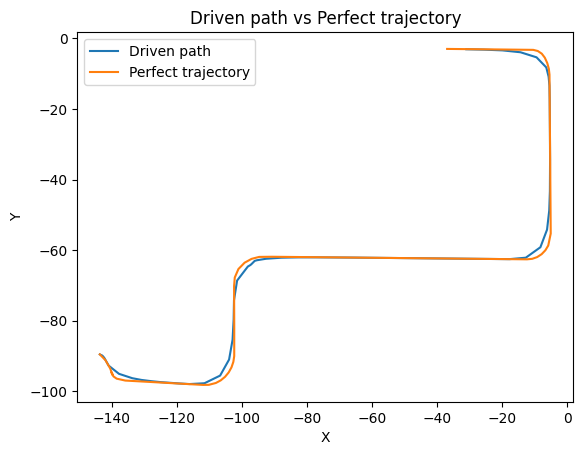

Average velocity: 0.82 m/s
Average acceleration: -0.04 m/s^2
Max acceleration: 1.89 m/s^2
Driven path length: 242.18 meters
Ideal trajectory length: 258.06 meters
DTW: 265.718517090911
Calculated score: 104.62
There are 68 generated scenarios
14


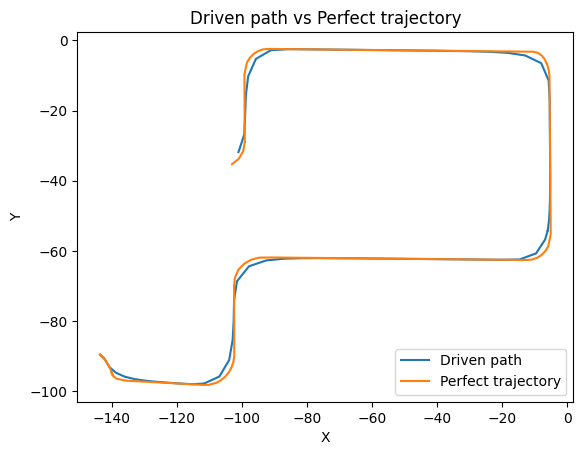

Average velocity: 0.28 m/s
Average acceleration: -0.03 m/s^2
Max acceleration: 2.26 m/s^2
Driven path length: 334.51 meters
Ideal trajectory length: 351.66 meters
DTW: 334.4402396779597
Calculated score: 665.31
There are 68 generated scenarios
36


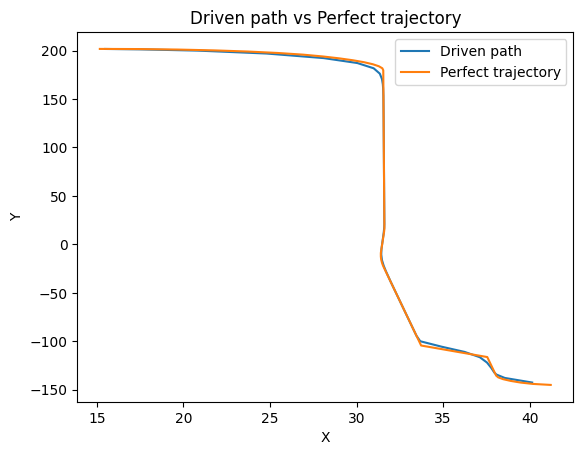

Average velocity: 0.12 m/s
Average acceleration: 0.01 m/s^2
Max acceleration: 1.61 m/s^2
Driven path length: 352.30 meters
Ideal trajectory length: 356.73 meters
DTW: 323.64914898006367
Calculated score: 676.22
There are 68 generated scenarios
48


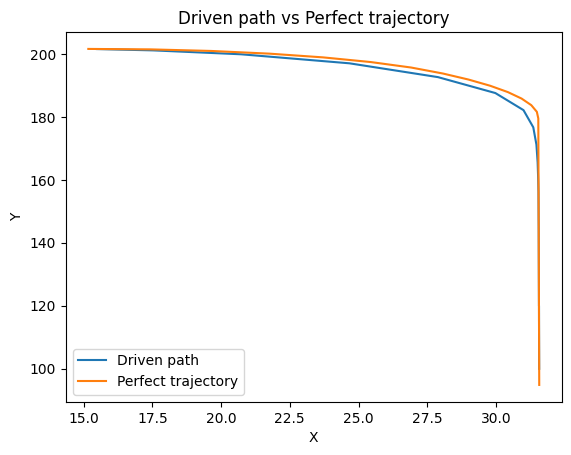

Average velocity: 0.21 m/s
Average acceleration: -0.00 m/s^2
Max acceleration: 1.60 m/s^2
Driven path length: 109.11 meters
Ideal trajectory length: 115.48 meters
DTW: 102.5516363897087
Calculated score: 897.24
There are 68 generated scenarios
20


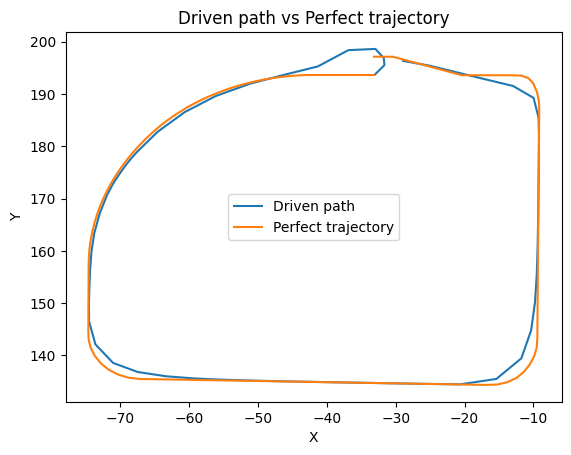

Average velocity: 0.03 m/s
Average acceleration: -0.06 m/s^2
Max acceleration: 1.72 m/s^2
Driven path length: 221.60 meters
Ideal trajectory length: 230.24 meters
DTW: 216.50370797360367
Calculated score: 39.18
There are 68 generated scenarios
17


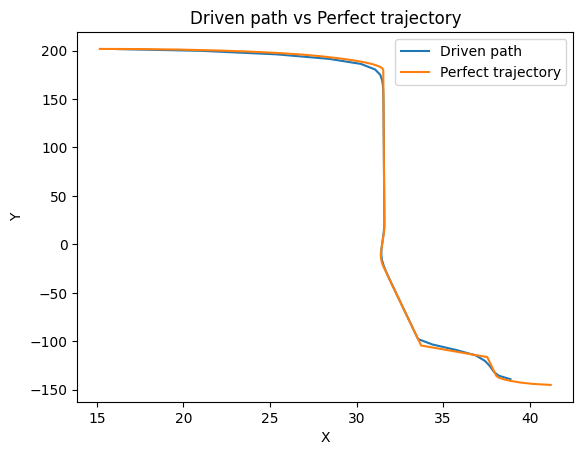

Average velocity: 0.11 m/s
Average acceleration: -0.00 m/s^2
Max acceleration: 1.54 m/s^2
Driven path length: 347.77 meters
Ideal trajectory length: 356.73 meters
DTW: 323.11795702775174
Calculated score: 676.77
There are 68 generated scenarios
7


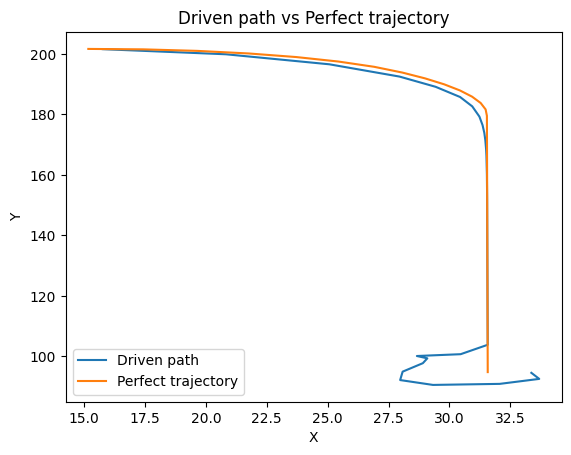

Average velocity: 0.12 m/s
Average acceleration: -0.03 m/s^2
Max acceleration: 2.06 m/s^2
Driven path length: 127.48 meters
Ideal trajectory length: 115.48 meters
DTW: 147.52415985026755
Calculated score: 121.57
There are 68 generated scenarios
19


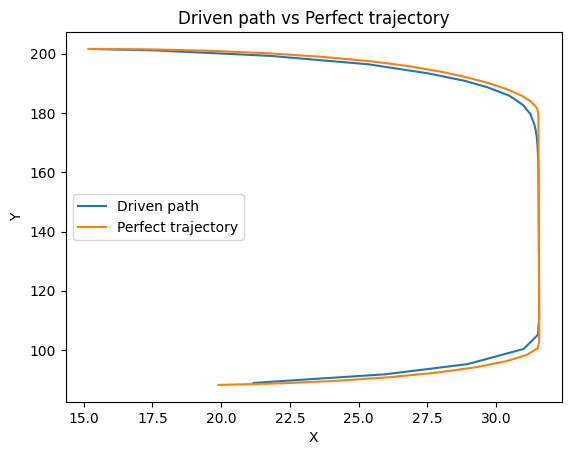

Average velocity: 0.03 m/s
Average acceleration: -0.03 m/s^2
Max acceleration: 2.36 m/s^2
Driven path length: 124.64 meters
Ideal trajectory length: 127.96 meters
DTW: 111.19786408892382
Calculated score: 888.80
There are 68 generated scenarios
57


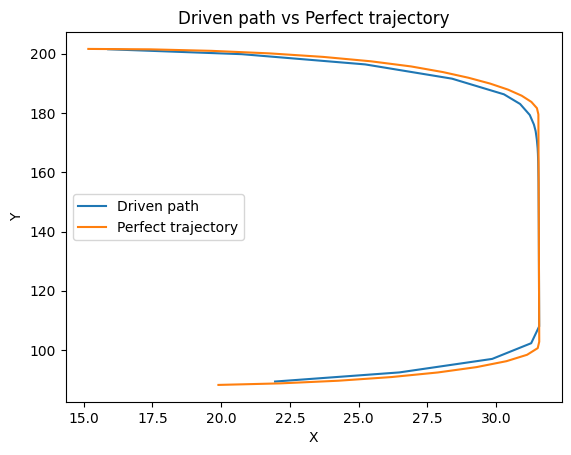

Average velocity: 0.02 m/s
Average acceleration: -0.05 m/s^2
Max acceleration: 1.40 m/s^2
Driven path length: 122.89 meters
Ideal trajectory length: 127.96 meters
DTW: 157.7805948678321
Calculated score: 842.25
There are 68 generated scenarios
8


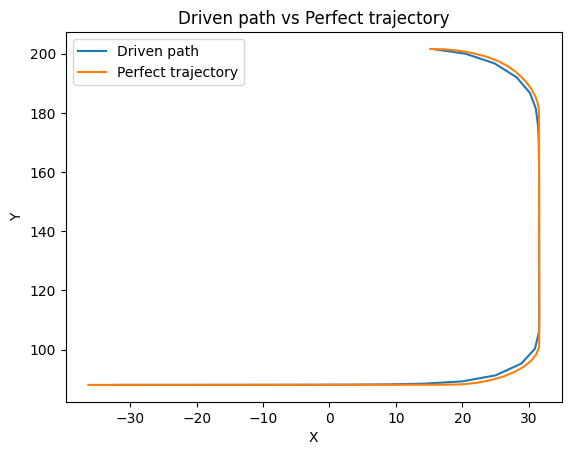

Average velocity: -0.60 m/s
Average acceleration: -0.06 m/s^2
Max acceleration: 2.48 m/s^2
Driven path length: 177.38 meters
Ideal trajectory length: 184.16 meters
DTW: 132.33826968810254
Calculated score: 868.31
There are 68 generated scenarios
34


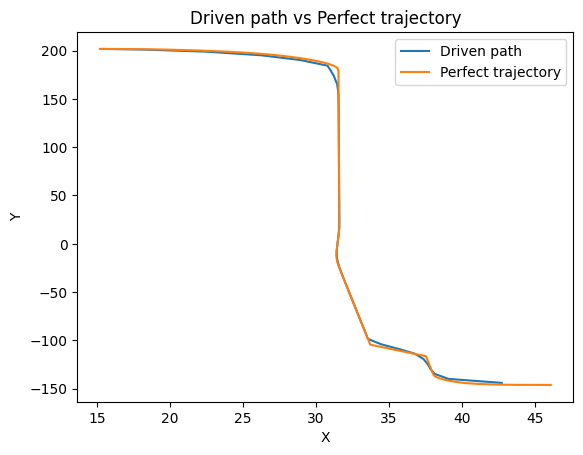

Average velocity: 0.13 m/s
Average acceleration: 0.02 m/s^2
Max acceleration: 1.78 m/s^2
Driven path length: 354.79 meters
Ideal trajectory length: 361.80 meters
DTW: 310.10636521517466
Calculated score: 689.75
There are 68 generated scenarios
32


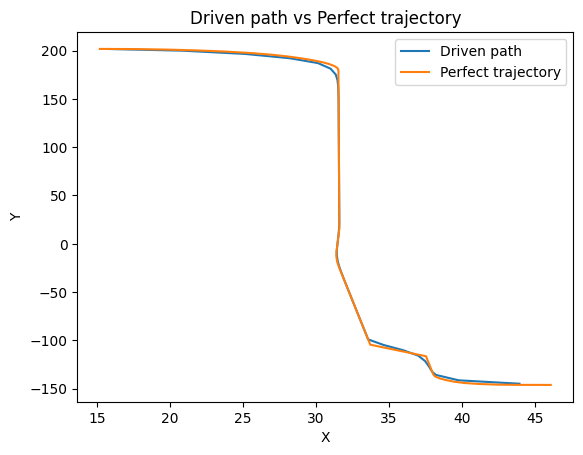

Average velocity: 0.19 m/s
Average acceleration: 0.02 m/s^2
Max acceleration: 1.75 m/s^2
Driven path length: 355.97 meters
Ideal trajectory length: 361.80 meters
DTW: 305.9174854563424
Calculated score: 693.88
There are 68 generated scenarios
29


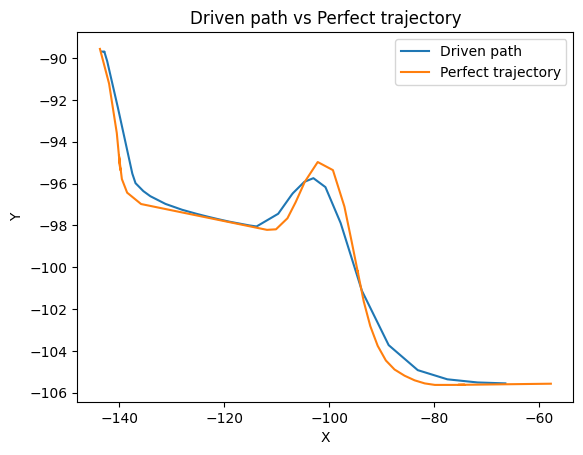

Average velocity: 1.73 m/s
Average acceleration: 0.09 m/s^2
Max acceleration: 2.04 m/s^2
Driven path length: 82.37 meters
Ideal trajectory length: 98.35 meters
DTW: 109.62256331923851
Calculated score: 86.63
There are 68 generated scenarios
51


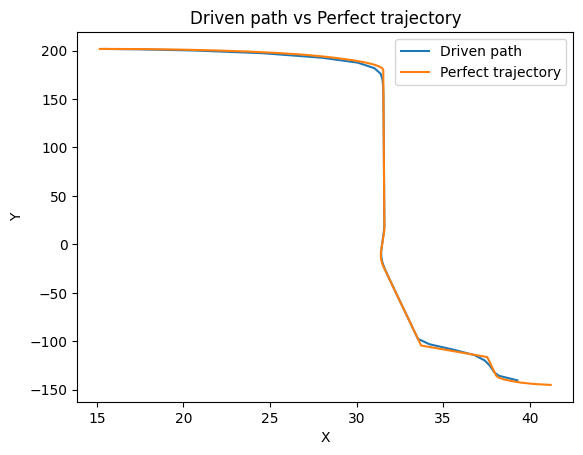

Average velocity: 0.11 m/s
Average acceleration: 0.01 m/s^2
Max acceleration: 1.65 m/s^2
Driven path length: 350.00 meters
Ideal trajectory length: 356.73 meters
DTW: 272.17354754849595
Calculated score: 727.70
There are 68 generated scenarios
2


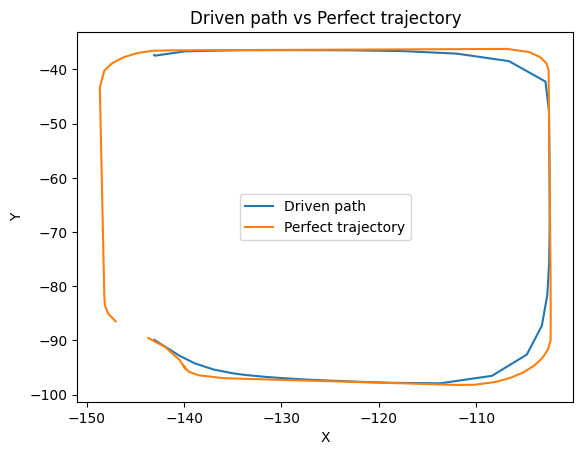

Average velocity: 0.01 m/s
Average acceleration: -0.04 m/s^2
Max acceleration: 2.70 m/s^2
Driven path length: 135.33 meters
Ideal trajectory length: 196.59 meters
DTW: 861.4410605187832
Calculated score: 6.93
There are 68 generated scenarios
18


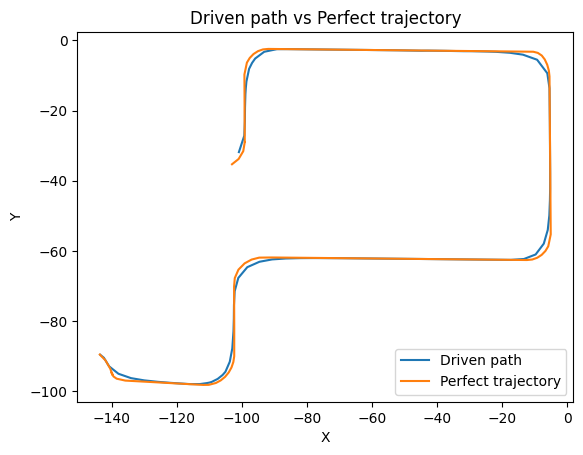

Average velocity: 0.23 m/s
Average acceleration: -0.02 m/s^2
Max acceleration: 1.63 m/s^2
Driven path length: 335.89 meters
Ideal trajectory length: 351.66 meters
DTW: 262.6225213813381
Calculated score: 737.17
There are 68 generated scenarios
52


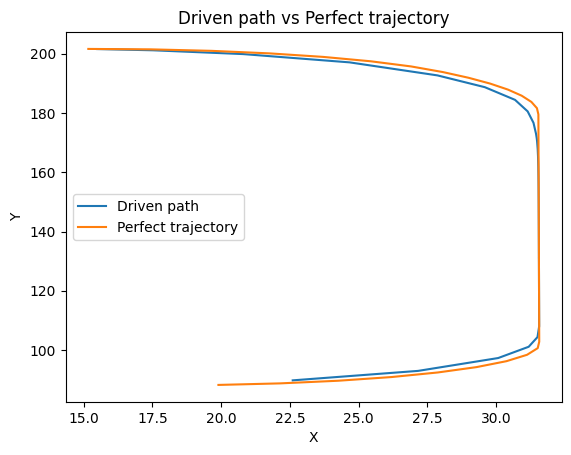

Average velocity: 0.05 m/s
Average acceleration: -0.06 m/s^2
Max acceleration: 1.58 m/s^2
Driven path length: 122.71 meters
Ideal trajectory length: 127.96 meters
DTW: 85.05659653299737
Calculated score: 914.96
There are 68 generated scenarios
0


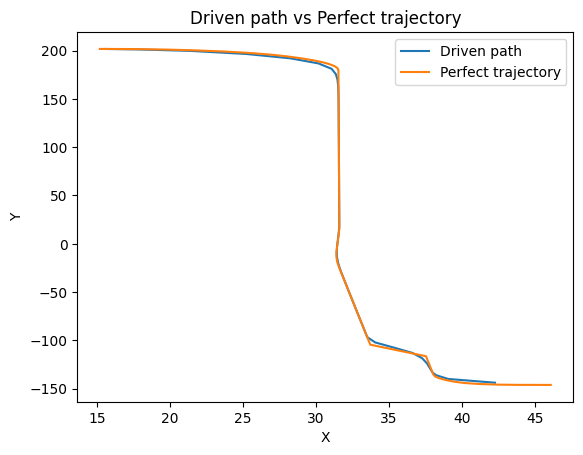

Average velocity: 0.13 m/s
Average acceleration: 0.03 m/s^2
Max acceleration: 2.90 m/s^2
Driven path length: 354.29 meters
Ideal trajectory length: 361.80 meters
DTW: 322.7822270194826
Calculated score: 677.06
There are 68 generated scenarios
55


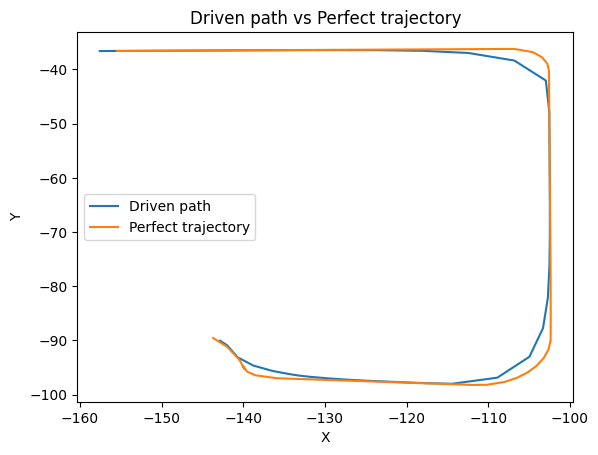

Average velocity: -0.32 m/s
Average acceleration: -0.19 m/s^2
Max acceleration: 2.39 m/s^2
Driven path length: 149.71 meters
Ideal trajectory length: 155.83 meters
DTW: 139.46420770406243
Calculated score: 861.05
There are 68 generated scenarios
11


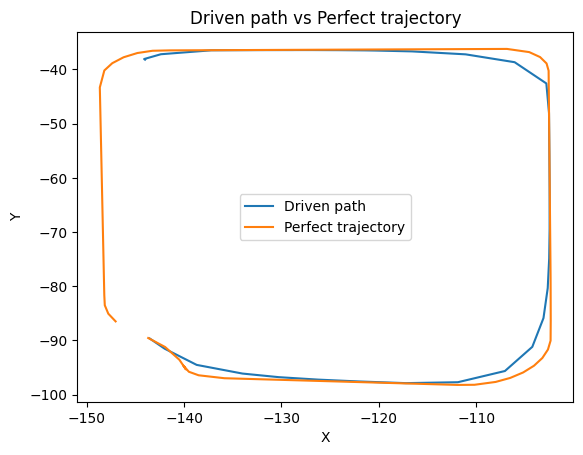

Average velocity: -0.04 m/s
Average acceleration: -0.01 m/s^2
Max acceleration: 2.74 m/s^2
Driven path length: 137.16 meters
Ideal trajectory length: 196.59 meters
DTW: 822.9925959839102
Calculated score: 8.85
There are 68 generated scenarios
56


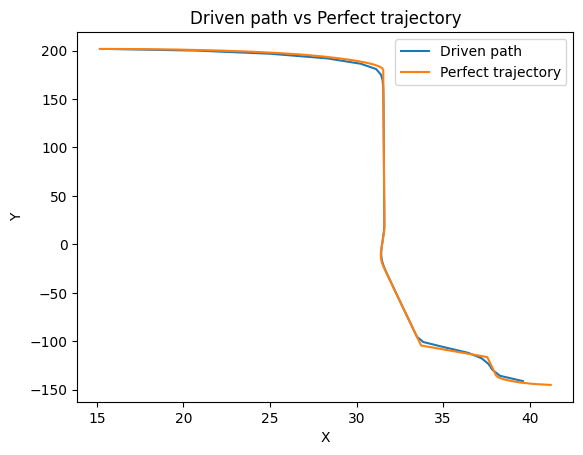

Average velocity: 0.16 m/s
Average acceleration: 0.00 m/s^2
Max acceleration: 1.68 m/s^2
Driven path length: 350.40 meters
Ideal trajectory length: 356.73 meters
DTW: 272.3215393484449
Calculated score: 727.52
There are 68 generated scenarios
23


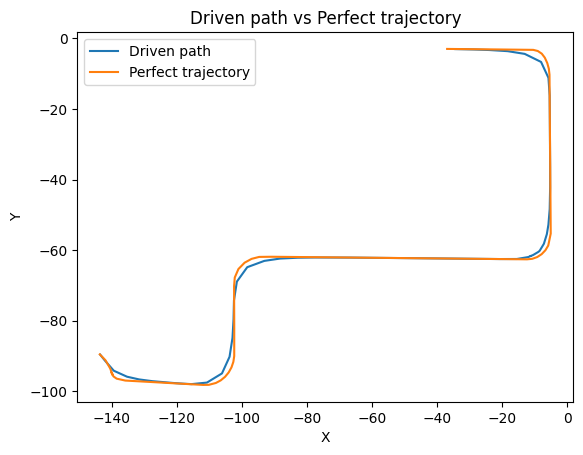

Average velocity: 0.55 m/s
Average acceleration: -0.03 m/s^2
Max acceleration: 2.08 m/s^2
Driven path length: 244.95 meters
Ideal trajectory length: 258.06 meters
DTW: 277.21968126805916
Calculated score: 36.11
There are 68 generated scenarios
46


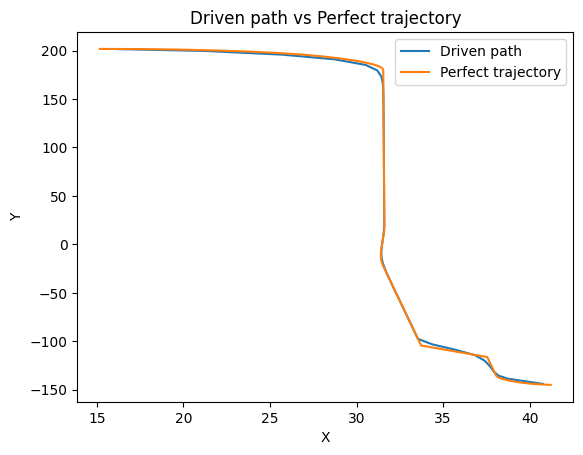

Average velocity: 0.12 m/s
Average acceleration: -0.00 m/s^2
Max acceleration: 0.98 m/s^2
Driven path length: 352.96 meters
Ideal trajectory length: 356.73 meters
DTW: 298.9637474183948
Calculated score: 700.92
There are 68 generated scenarios
54


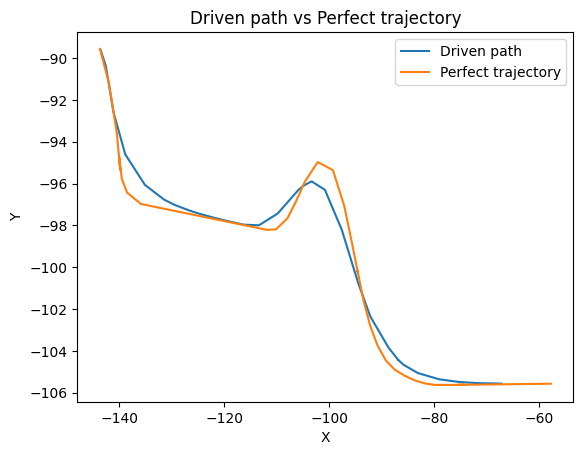

Average velocity: 1.56 m/s
Average acceleration: 0.12 m/s^2
Max acceleration: 1.66 m/s^2
Driven path length: 81.70 meters
Ideal trajectory length: 98.35 meters
DTW: 92.0129965397872
Calculated score: 45.32
There are 68 generated scenarios
31


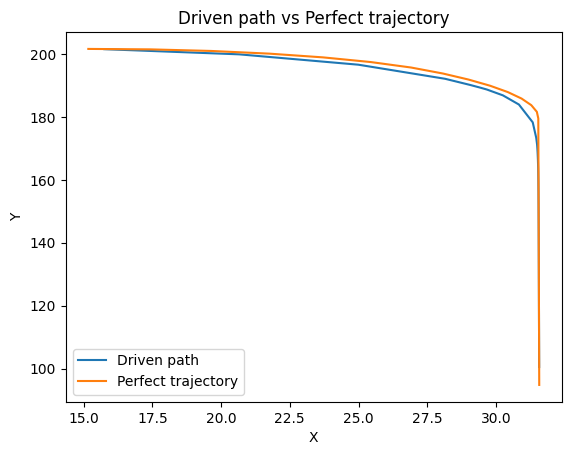

Average velocity: 0.19 m/s
Average acceleration: -0.02 m/s^2
Max acceleration: 2.00 m/s^2
Driven path length: 108.25 meters
Ideal trajectory length: 115.48 meters
DTW: 112.1406416066328
Calculated score: 887.68
There are 68 generated scenarios
28


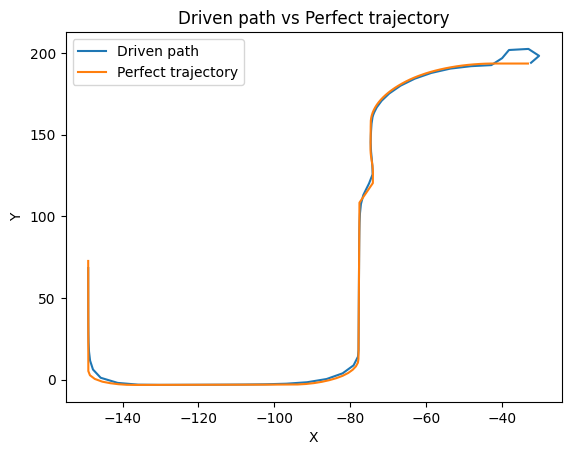

Average velocity: -1.12 m/s
Average acceleration: -0.04 m/s^2
Max acceleration: 2.51 m/s^2
Driven path length: 366.76 meters
Ideal trajectory length: 359.93 meters
DTW: 305.0778420366698
Calculated score: 34.80
There are 68 generated scenarios
59


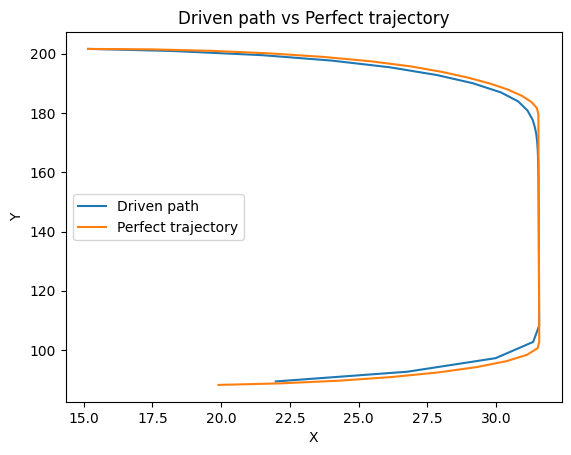

Average velocity: 0.03 m/s
Average acceleration: -0.03 m/s^2
Max acceleration: 1.23 m/s^2
Driven path length: 123.72 meters
Ideal trajectory length: 127.96 meters
DTW: 144.24845359105018
Calculated score: 855.76
There are 68 generated scenarios
67


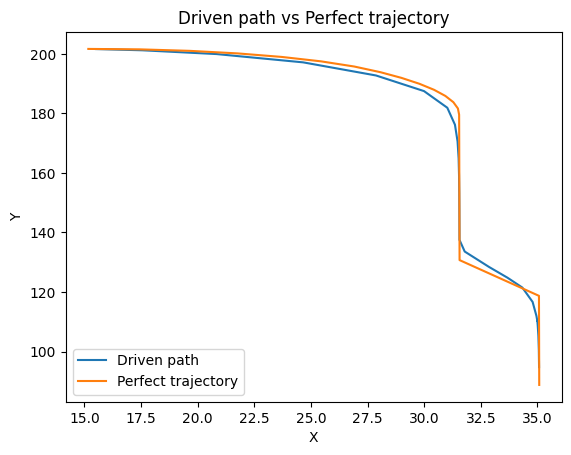

Average velocity: 0.27 m/s
Average acceleration: -0.00 m/s^2
Max acceleration: 1.57 m/s^2
Driven path length: 114.55 meters
Ideal trajectory length: 121.98 meters
DTW: 110.21617889665431
Calculated score: 889.52
There are 68 generated scenarios
6


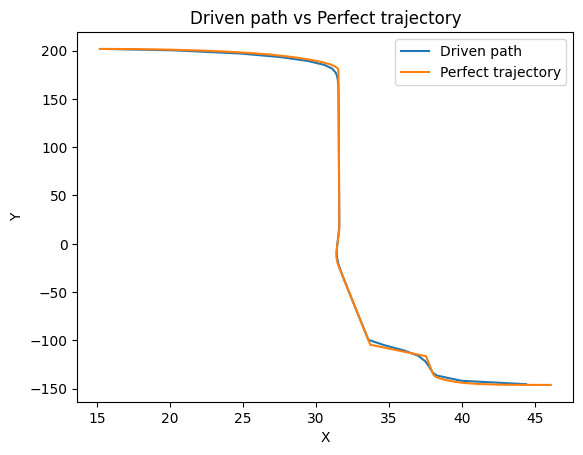

Average velocity: 0.14 m/s
Average acceleration: 0.02 m/s^2
Max acceleration: 2.76 m/s^2
Driven path length: 356.91 meters
Ideal trajectory length: 361.80 meters
DTW: 309.3925684148695
Calculated score: 690.44
There are 68 generated scenarios
4


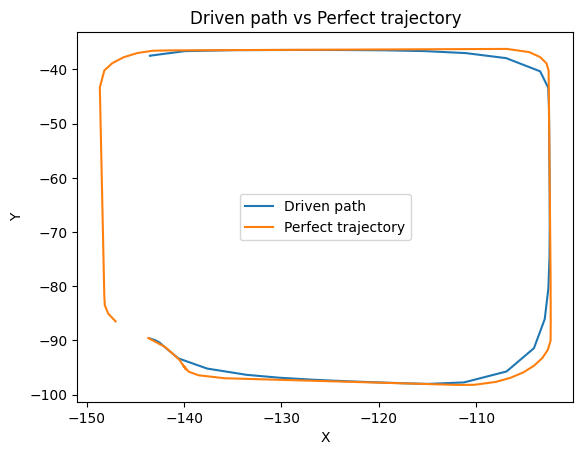

Average velocity: -0.02 m/s
Average acceleration: -0.01 m/s^2
Max acceleration: 2.56 m/s^2
Driven path length: 137.27 meters
Ideal trajectory length: 196.59 meters
DTW: 836.5661682601565
Calculated score: 8.17
There are 68 generated scenarios
47


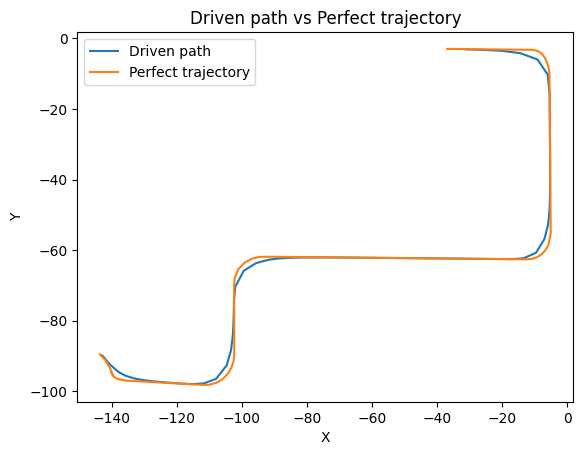

Average velocity: 0.57 m/s
Average acceleration: -0.03 m/s^2
Max acceleration: 1.95 m/s^2
Driven path length: 240.70 meters
Ideal trajectory length: 258.06 meters
DTW: 240.27467788283636
Calculated score: 37.96
There are 68 generated scenarios
26


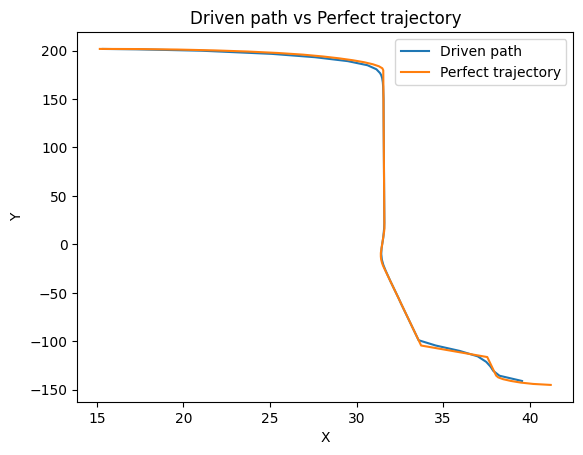

Average velocity: 0.11 m/s
Average acceleration: 0.01 m/s^2
Max acceleration: 2.10 m/s^2
Driven path length: 350.77 meters
Ideal trajectory length: 356.73 meters
DTW: 326.3080313802027
Calculated score: 673.57
There are 68 generated scenarios
25


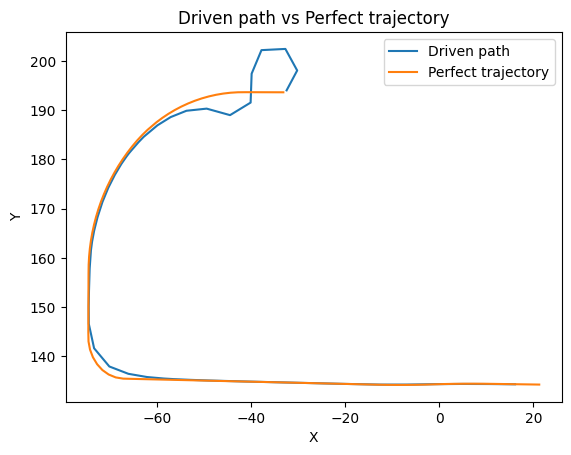

Average velocity: 0.31 m/s
Average acceleration: 0.01 m/s^2
Max acceleration: 2.72 m/s^2
Driven path length: 188.68 meters
Ideal trajectory length: 177.21 meters
DTW: 210.89298476053452
Calculated score: 788.78
There are 68 generated scenarios
9


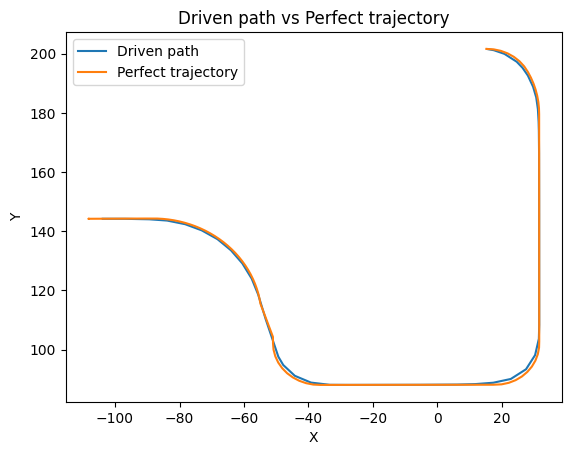

Average velocity: -0.85 m/s
Average acceleration: -0.04 m/s^2
Max acceleration: 2.43 m/s^2
Driven path length: 280.37 meters
Ideal trajectory length: 288.96 meters
DTW: 226.9792205961405
Calculated score: 773.91
There are 68 generated scenarios


In [30]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from dtw import *
import math
import json
import matplotlib.pyplot as plt
import numpy as np
import os

rated_objects = []
count = 0
for root, dirs, files in os.walk('user_input/NN_run/step2'):
    for file in files:
        if 'auto_scenario' in file:
        
            
            # Extract the number from the file name
            scenario_num = int(file.split('_')[-1].split('.')[0])
            print(scenario_num)
            # Open the corresponding route file
            with open(f'user_input/NN_run/step1/random_route_{scenario_num}.json', 'r') as f:
                trajectory = json.load(f)

            with open(f'user_input/NN_run/step2/auto_scenario_{scenario_num}.json') as f:
                driven_path_data = json.load(f)

          

            def get_trajectory_length(trajectory):
                # Extract the X and Y coordinates from each location
                x_coords = [location['X'] for location in trajectory]
                y_coords = [location['Y'] for location in trajectory]

                # Compute the Euclidean distances between consecutive points
                distances = [math.sqrt((x2 - x1)**2 + (y2 - y1)**2) for x1, y1, x2, y2 in zip(x_coords[:-1], y_coords[:-1], x_coords[1:], y_coords[1:])]

                # Return the total length of the trajectory
                return sum(distances)

            def path_length(path):
                length = 0
                for i in range(1, len(path)):
                    x1, y1 = path[i-1]
                    x2, y2 = path[i]
                    segment_length = math.sqrt((x2-x1)**2 + (y2-y1)**2)
                    length += segment_length
                return length

    
            driven_path = [(d['vehicle_location']['x'], d['vehicle_location']['y']) for d in driven_path_data]
            
            # Plot the driven path
            plt.plot(*zip(*driven_path), label='Driven path')

            # Extract the X and Y coordinates from each location
            x_coords = [location['X'] for location in trajectory]
            y_coords = [location['Y'] for location in trajectory]

            # Plot the route on a graph
            plt.plot(x_coords, y_coords, label='Perfect trajectory')

            plt.title('Driven path vs Perfect trajectory')
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.legend()
            plt.show()

            # Initialize lists to store data
            timestamps = []
            velocities = []
            throttles = []

            # Extract values from data
            game_time = [entry['game_time'] for entry in driven_path_data]
            velocity = [entry['vehicle_velocity']['x'] for entry in driven_path_data]
            throttle = [entry['vehicle_throttle'] for entry in driven_path_data]

            # Calculate average velocity
            avg_velocity = np.mean(velocity)
            print(f'Average velocity: {avg_velocity:.2f} m/s')

            # Calculate acceleration
            dt = np.mean(np.diff(game_time))
            acceleration = np.gradient(velocity, dt)
            avg_acceleration = np.mean(acceleration)
            print(f'Average acceleration: {avg_acceleration:.2f} m/s^2')
            max_acceleration = max(acceleration)
            print(f'Max acceleration: {max_acceleration:.2f} m/s^2')

            driven_path_length = path_length(driven_path)
            print(f"Driven path length: {driven_path_length:.2f} meters")
            
            ideal_trajectory_length = get_trajectory_length(trajectory)
            print(f"Ideal trajectory length: {ideal_trajectory_length:.2f} meters")


            last_object = driven_path_data[-1]
            num_collisions = last_object["unique_collisions"]
            solid_lane_crosses = last_object["solid_lane_crosses"]
            double_solid_lane_crosses = last_object["double_solid_lane_crosses"]

            # def new_rate_driven_path(trajectory,ideal_trajectory_length, driven_path, driven_path_length, 
            #                          avg_velocity, avg_acceleration, num_collisions, solid_lane_crosses, double_solid_lane_crosses):
            #     # Calculate the DTW distance between the trajectory and driven path
            #     distance, _ = fastdtw(trajectory, driven_path, dist=euclidean)
                
            #     print("DTW: " + str(distance))
            #     print("Collisions: " + str(num_collisions))
            #     print("Solid lane crosses: " + str(solid_lane_crosses))
            #     print("Double solid lane crosses: " + str(double_solid_lane_crosses))
            #     # Set the maximum safety score
            #     max_score = 1000
                
            #     # Calculate the safety score based on distance, velocity, and acceleration
            #     velocity_factor = 1  # Weighting factor for velocity
            #     acceleration_factor = 2  # Weighting factor for acceleration
            #     driven_length_factor = driven_path_length / ideal_trajectory_length  # Scaling factor based on completed length ratio
            #     ideal_trajectory_length_factor = ideal_trajectory_length/10
            #     safety_score = max_score*ideal_trajectory_length_factor*driven_length_factor - distance - velocity_factor * avg_velocity - acceleration_factor * avg_acceleration
            #     # safety_score = max_score*ideal_trajectory_length_factor*driven_length_factor - distance 
                
            #     # Penalize for number of collisions
            #     if num_collisions > 0:
            #         safety_score -= safety_score * (0.95 ** num_collisions)
                
            #     if solid_lane_crosses > 0:
            #         # Penalize for solid lane crosses
            #         solid_lane_cross_penalty = 10
            #         safety_score = safety_score - solid_lane_crosses * solid_lane_cross_penalty
                
            #     if double_solid_lane_crosses > 0:
            #         # Penalize for double solid lane crosses
            #         double_solid_lane_cross_penalty = 30
            #         safety_score = safety_score - double_solid_lane_crosses * double_solid_lane_cross_penalty
                
            #     return safety_score

            def rate_driven_path(trajectory, driven_path, avg_velocity,avg_acceleration,num_collisions):
                # Calculate the DTW distance between the trajectory and driven path
                distance, _ = fastdtw(trajectory, driven_path, dist=euclidean)
                
                print("DTW: "+str(distance))
                # Calculate the safety score based on DTW distance and average velocity
                safety_score = 1000 - distance - avg_velocity -avg_acceleration 
                
                # Penalize for number of collisions
                if num_collisions > 0:
                    safety_score -= safety_score * (0.95**num_collisions)
            
                return safety_score

            # # # Plot velocity over time
            # plt.plot(game_time, velocity)
            # plt.xlabel('Time (s)')
            # plt.ylabel('Velocity (m/s)')
            # plt.show()

            # # Plot acceleration over time
            # plt.plot(game_time, acceleration)
            # plt.xlabel('Time (s)')
            # plt.ylabel('Acceleration (m/s^2)')
            # plt.show()

            perfect_trajectory_array = list(zip(x_coords, y_coords))
            driven_path_array = np.array(driven_path)

            calculated_score = rate_driven_path(perfect_trajectory_array,
                                                    
                                                    driven_path_array,
                                                    
                                                    avg_velocity,
                                                    avg_acceleration,
                                                    num_collisions,
                                                   )
            
            print(f'Calculated score: {calculated_score:.2f}')
           
            # Open the file for reading
            with open('user_input/NN_run/step1/random_scenarios.json', 'r') as f:
                data = json.load(f)

            print(f'There are {len(data)} generated scenarios')
            
           
            # Find the object with the desired scenario_num
            for obj in data:
                if obj['scenario_num'] == scenario_num:
                    # Add the new variable
                    obj['calculated_score'] = calculated_score  # Replace 0 with your desired value
                    rated_objects.append(obj)

# Open the file for writing
with open('user_input/NN_run/step3/rated_scenarios.json', 'w') as f:
    json.dump(rated_objects, f,indent=4)

Step 4: Train NN MLP on rated scenarios

In [31]:
import json
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.neural_network import MLPRegressor

# Load data from JSON file
with open('user_input/NN_run/step3/rated_scenarios.json', 'r') as f:
    data = json.load(f)

# Extract features and target variable
X = []
y = []
for obj in data:
    X.append([
        obj['weather'],
        obj['vehicle'],
        obj['traffic'],
        obj['emergency'],
        obj['timeOfDay'],
        obj['location'],
        obj['intersections'],
        int(obj['pedestrians']),
        int(obj['pedestrian_cross']),
        obj['rounded_route_length'],
        
    ])
    
    y.append(obj['calculated_score'])
X = np.array(X)
y = np.array(y)

# Encode categorical features
categorical_features = [0, 1, 2, 3, 4, 5]
encoders = []
for i in categorical_features:
    le = LabelEncoder()
    ohe = OneHotEncoder(sparse=False)
    X[:, i] = le.fit_transform(X[:, i])
    encoders.append((le, ohe))
X = ohe.fit_transform(X)

# Split data into training and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train neural network regressor
nn = MLPRegressor(hidden_layer_sizes=(100,), max_iter=100000)
nn.fit(X_train, y_train)

# Make predictions on test set
y_pred = nn.predict(X_test)

# Evaluate model performance (e.g. using mean squared error)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse:.2f}')


MSE: 83273.91


Step 5: Generate new random scenarios 

In [3]:
import json
import os 
import re
import random
import carla
from agents.navigation.global_route_planner import GlobalRoutePlanner
class ScenarioGenerator:
    def __init__(self, weather, vehicle, traffic, emergency, timeOfDay, location, intersections, pedestrians, pedestrian_cross,route_length, num_scenarios):
        self.weather = weather
        self.vehicle = vehicle
        self.traffic = traffic
        self.emergency = emergency
        self.timeOfDay = timeOfDay
        self.location = location
        self.intersections = intersections
        self.pedestrians = pedestrians
        self.pedestrian_cross = pedestrian_cross
        self.num_scenarios = num_scenarios
        self.route_length = route_length
        
    def generate_scenarios(self):
        

         # Create dictionaries that map each variable value to a difficulty rating
        weather_difficulty = {'Sunny': 1, 'Rain': 5, 'Thunderstorm': 8}
        vehicle_difficulty = {'Small': 1, 'Truck': 2,'Van': 3}
        traffic_difficulty = {'Heavy': 6, 'Light': 1,'Medium': 3}
        emergency_difficulty = {'Yes': 10, 'No': 0}
        timeOfDay_difficulty = {'Day': 1, 'Night':5,'Dawn':2,'Dusk':2}
        location_difficulty = {'Urban':4 , 'Country' :1 ,'Downtown' :3 }
        intersections_difficulty = {0:1 ,1:2 ,2:3 ,3:4 ,4:5 ,5:6 }
        pedestrians_difficulty = {True: 0.5 ,False : 0}
        pedestrian_cross_difficulty = {True : 10, False : 0 }
        route_length_difficulty ={50 :0.5 ,100 :1.5,200 : 2 ,250:2.5,300:3,400:4,500:5,600:6}

        generated_scenarios = []
        directory = 'user_input/NN_run/step5'
        highest_number = 0

        for filename in os.listdir(directory):
            match = re.search(r'random_route_(\d+)', filename)
            if match:
                number = int(match.group(1))
                if number > highest_number:
                    highest_number = number
        

        for i in range(highest_number,self.num_scenarios+highest_number):
            # Randomly choose values for each variable
            weather_choice = random.choice(self.weather)
            vehicle_choice = random.choice(self.vehicle)
            traffic_choice = random.choice(self.traffic)
            emergency_choice= random.choice(self.emergency)
            timeOfDay_choice= random.choice(self.timeOfDay)
            location_choice= random.choice(self.location)
            intersections_choice= random.choice(self.intersections)
            pedestrians_choice= random.choice(self.pedestrians)
            pedestrian_cross_choice= random.choice(self.pedestrian_cross)
            route_length_choice=random.choice(self.route_length)

            
            client = carla.Client("localhost", 2000)
            
            if location_choice == "Downtown":
                world = client.load_world('Town05')
            if location_choice == "Urban":
                world = client.load_world('Town03')
            if location_choice == "Country":
                world = client.load_world('Town07')
            
            map = world.get_map()
            grp = GlobalRoutePlanner(map,2)
 
            waypoints = map.generate_waypoints(2.0)


            def get_route_length(route):
                length = 0
                for i in range(len(route) - 1):
                    length += route[i][0].transform.location.distance(route[i + 1][0].transform.location)
                return length
            
            start_waypoint = 0
            end_waypoint = 0
            for start_waypoint in waypoints:
                for end_waypoint in waypoints:
    
                    route = grp.trace_route(start_waypoint.transform.location, end_waypoint.transform.location)
                    found_route_length = get_route_length(route)
                
                    # Get unique road IDs
                    road_ids = list(set(waypoint[0].road_id for waypoint in route))
                    junction_road_ids = []
                    junctions_on_route = 0
                    if intersections_choice > 0:
                        for road_id in road_ids:
                            # waypoints = map.generate_waypoints(2.0)
                            for waypoint in route:
                                if waypoint[0].road_id == road_id and waypoint[0].is_junction:
                                    junction_road_ids.append(road_id)
                                    # draw_waypoints(waypoints, road_id=road_id, life_time=300)
                        junctions_on_route = len(list(set(junction_road_ids)))

                    if (found_route_length > (route_length_choice-(route_length_choice*0.2)) 
                        and found_route_length < (route_length_choice+(route_length_choice*0.2))
                        and junctions_on_route >= intersections_choice):
                    
                        found = True
                        start_waypoint = start_waypoint.transform.location
                        end_waypoint = end_waypoint.transform.location

                        # Get unique road IDs
                        road_ids = list(set(waypoint[0].road_id for waypoint in route))

                        junction_road_ids = []
                        junctions_on_route = 0
                        for road_id in road_ids:
                            # waypoints = map.generate_waypoints(2.0)
                            for waypoint in route:
                                if waypoint[0].road_id == road_id and waypoint[0].is_junction:
                                    junction_road_ids.append(road_id)
                    
                        junctions_on_route = len(list(set(junction_road_ids)))
                     
                        total_difficulty_rating = (weather_difficulty[weather_choice] +
                            vehicle_difficulty[vehicle_choice] +
                            traffic_difficulty[traffic_choice] +
                            emergency_difficulty[emergency_choice] +
                            timeOfDay_difficulty[timeOfDay_choice] +
                            location_difficulty[location_choice]+
                            (junctions_on_route*5)+
                            pedestrians_difficulty[pedestrians_choice]+
                            pedestrian_cross_difficulty[pedestrian_cross_choice]+
                                    found_route_length)
                        
                       
                        # Create a scenario dictionary with the chosen variable values and total difficulty rating
                        scenario = {
                            'scenario_num': i,
                            'weather': weather_choice,
                            'vehicle': vehicle_choice,
                            'traffic': traffic_choice,
                            'emergency': emergency_choice,
                            'timeOfDay': timeOfDay_choice,
                            'location': location_choice,
                            "intersections": junctions_on_route,
                            "pedestrians": pedestrians_choice,
                            "pedestrian_cross": pedestrian_cross_choice,
                            "start_x": start_waypoint.x,
                            "start_y": start_waypoint.y,
                            "end_x": end_waypoint.x,
                            "end_y": end_waypoint.y,
                            "rounded_route_length": route_length_choice,
                            "route_length": found_route_length,
                            "total_difficulty_rating": total_difficulty_rating
                        }

                        # Create a list of dictionaries representing each location in the route
                        locations = []
                        for waypoint, _ in route:
                            location = waypoint.transform.location
                            locations.append({'X': location.x, 'Y': location.y})

                        # Save the locations to a JSON file
                        with open(f'user_input/NN_run/step5/random_route_{i}.json', 'w') as f:
                            json.dump(locations, f,indent=4)

                        generated_scenarios.append(scenario)
                              
                        with open('user_input/NN_run/step5/random_scenarios.json', 'w') as f:
                            json.dump(generated_scenarios, f, indent=4)

                        break
                        # build path using the route
                if found:
                    break
        
  
        
        return generated_scenarios

weather = ['Sunny', 'Rain', 'Thunderstorm']
vehicle = ['Small', 'Truck','Van']
traffic = ['Heavy', 'Light','Medium']
emergency = ['Yes', 'No']
timeOfDay = ['Day', 'Night','Dawn','Dusk']
location = ['Urban', 'Country','Downtown']
intersections = [0,1,2,3,4]
pedestrians = [True,False]
pedestrian_cross = [True, False]
route_length = [100,150,200,250,300,350,400]
num_scenarios = 4


scenario_generator = ScenarioGenerator(weather, vehicle, traffic, emergency, timeOfDay, location, intersections, pedestrians, pedestrian_cross,route_length, num_scenarios)
random_scenarios = scenario_generator.generate_scenarios()

Step 6: Predict the actor safety score in these scenarios and filter out easy scenarios

In [33]:
import numpy as np
import json

# Load data from JSON file
with open('user_input/NN_run/step5/random_scenarios.json', 'r') as f:
    data = json.load(f)

# Extract features
X_unrated = []
for obj in data:
    X_unrated.append([
        obj['weather'],
        obj['vehicle'],
        obj['traffic'],
        obj['emergency'],
        obj['timeOfDay'],
        obj['location'],
        obj['intersections'],
        int(obj['pedestrians']),
        int(obj['pedestrian_cross']),
        obj['rounded_route_length']
    ])

X_unrated = np.array(X_unrated)

# Encode categorical features
for i in categorical_features:
    le, ohe = encoders[i]
    X_unrated[:, i] = le.transform(X_unrated[:, i])
X_unrated = ohe.transform(X_unrated)

# Make predictions on unrated scenarios
y_pred_unrated = nn.predict(X_unrated)


# Create a new list to store scenarios with predicted score >= 500
high_score_scenarios = []
rejected_scenarios = []

for obj, pred in zip(data, y_pred_unrated):
    print(f"W: {obj['weather']}, V: {obj['vehicle']}, T: {obj['traffic']}, E: {obj['emergency']}, TD: {obj['timeOfDay']}, L: {obj['location']}, I: {obj['intersections']}, P: {int(obj['pedestrians'])}, PC: {int(obj['pedestrian_cross'])}, RL: {obj['route_length']}")
    print(f"Predicted Score: {pred:.2f}")
    print()
    obj['predicted_score'] = pred
    high_score_scenarios.append(obj)

# Write updated data to JSON file
with open('user_input/NN_run/step6/high_score_scenarios.json', 'w') as f:
    json.dump(high_score_scenarios, f, indent=4) 





W: Sunny, V: Small, T: Heavy, E: Yes, TD: Dawn, L: Country, I: 7, P: 0, PC: 0, RL: 155.83429431915283
Predicted Score: 610.17

W: Rain, V: Small, T: Light, E: Yes, TD: Dawn, L: Downtown, I: 4, P: 1, PC: 0, RL: 115.47674536705017
Predicted Score: 687.64

W: Sunny, V: Truck, T: Heavy, E: No, TD: Dusk, L: Urban, I: 8, P: 0, PC: 0, RL: 230.24243074655533
Predicted Score: -342.21

W: Thunderstorm, V: Van, T: Medium, E: No, TD: Day, L: Urban, I: 5, P: 0, PC: 0, RL: 281.91450119018555
Predicted Score: 485.30

W: Rain, V: Small, T: Heavy, E: No, TD: Dusk, L: Downtown, I: 6, P: 1, PC: 1, RL: 288.96105766296387
Predicted Score: 718.82



Step 7: Run the filtered scenarios 

In [1]:

import carla
import json
import os
import re
import time 
from agents.navigation.global_route_planner import GlobalRoutePlanner
import random
import math
from agents.navigation.basic_agent import BasicAgent
from carla import WeatherParameters
import logging
from carla import VehicleLightState as vls

 # Open the JSON file
with open("user_input/NN_run/step6/high_score_scenarios.json", "r") as file:
    scenario_data = json.load(file)

directory = 'user_input/NN_run/step7'
highest_number = 0

# for filename in os.listdir(directory):
#     match = re.search(r'auto_scenario_(\d+).json', filename)
#     if match:
#         number = int(match.group(1))
#         if number > highest_number:
#             highest_number = number

# Initialize variables with the values from the JSON file
def main():
    print("Number: "+ str(highest_number))
    for scenario_num in range(highest_number,len(scenario_data)):
        try:
           
            weather = scenario_data[scenario_num]["weather"]
            intersections = scenario_data[scenario_num]["intersections"]
            vehicle = scenario_data[scenario_num]["vehicle"]
            traffic = scenario_data[scenario_num]["traffic"]
            emergency = scenario_data[scenario_num]["emergency"]
            timeOfDay = scenario_data[scenario_num]["timeOfDay"]
            location = scenario_data[scenario_num]["location"]
            pedestrians = scenario_data[scenario_num]["pedestrians"]
            pedestrian_cross = scenario_data[scenario_num]["pedestrian_cross"]
            start_x = scenario_data[scenario_num]["start_x"]
            start_y = scenario_data[scenario_num]["start_y"]
            end_x = scenario_data[scenario_num]["end_x"]
            end_y = scenario_data[scenario_num]["end_y"]
            route_length = scenario_data[scenario_num]["route_length"]
            total_difficulty_rating = scenario_data[scenario_num]["total_difficulty_rating"]
            scenario_num = scenario_data[scenario_num]["scenario_num"]


            client = carla.Client("localhost", 2000)

            if location == "Downtown":
                world = client.load_world('Town05')
            if location == "Urban":
                world = client.load_world('Town03')
            if location == "Country":
                world = client.load_world('Town07')

            spectator = world.get_spectator()
            map = world.get_map()

            traffic_manager = client.get_trafficmanager(8000)
            traffic_manager.set_global_distance_to_leading_vehicle(2.5)
            traffic_manager.set_synchronous_mode(True)
            traffic_manager.global_percentage_speed_difference(50.0)


            cloudiness=0.0,
            precipitation=0.0,
            sun_altitude_angle=70.0  # 70 degrees is around noon

            # Set the weather conditions
            if weather == "Sunny":
                cloudiness=10
                precipitation=0.0
                precipitation_deposits=0

            elif weather == "Rain":
                cloudiness=80
                precipitation=60.0
                precipitation_deposits=30
                
            elif weather == "Thunderstorm":
                cloudiness=100
                precipitation=90.0
                precipitation_deposits=60
                

            if timeOfDay == "Day":
                sun_altitude_angle=70.0
            elif timeOfDay == "Night":
                sun_altitude_angle=-30.0
            elif timeOfDay == "Dawn":
                sun_altitude_angle=20.0
            elif timeOfDay == "Dusk":
                sun_altitude_angle=110.0

            weather_params = WeatherParameters(
                cloudiness=cloudiness,
                precipitation=precipitation,
                sun_altitude_angle=sun_altitude_angle,  
                precipitation_deposits=precipitation_deposits 
            )

            # Set the weather in the simulation
            world.set_weather(weather_params)

    
            grp = GlobalRoutePlanner(map,2)

            spawn_points = map.get_spawn_points()

            # Set the desired number of junctions
            num_junctions = intersections

            waypoints = map.generate_waypoints(2.0)

            def draw_waypoints(waypoints, road_id=None, life_time=50.0):
                spawned = False 
                for waypoint in waypoints:
                    
                    if(waypoint.road_id == road_id):
                        world.debug.draw_string(waypoint.transform.location, "JUNC", draw_shadow=False,
                                                color=carla.Color(r=0, g=255, b=0), life_time=life_time,
                                                persistent_lines=True)

            def get_route_length(route):
                length = 0
                for i in range(len(route) - 1):
                    length += route[i][0].transform.location.distance(route[i + 1][0].transform.location)
                return length
            
            start_location = carla.Location(x=start_x,y=start_y)
            end_location = carla.Location(x=end_x,y=end_y)
            
            # print(start_waypoint.transform.location.distance(end_waypoint.transform.location))
            route = grp.trace_route(start_location,end_location)
        
                    
            # The 'waypoints' variable now contains a list of waypoints that define a route between 'start_pose' and 'end_pose' that goes through 'num_junctions' junctions.

            i = 0
            for w in route:
                if i % 10 == 0:
                    world.debug.draw_string(w[0].transform.location, 'O', draw_shadow=False,
                    color=carla.Color(r=255, g=0, b=0), life_time=1000.0,
                    persistent_lines=True)
                else:
                    world.debug.draw_string(w[0].transform.location, 'O', draw_shadow=False,
                    color = carla.Color(r=0, g=0, b=255), life_time=1000.0,
                    persistent_lines=True)
                i += 1

            vehicles_list = []
            walkers_list = []
            all_id = []

            def spawn_random_pedestrians_and_cars(world, route):
                # Get the blueprint library
                blueprint_library = world.get_blueprint_library()

                # Get the pedestrian and car blueprints
                pedestrian_blueprints = blueprint_library.filter("walker.pedestrian.*")
                car_blueprints = blueprint_library.filter("vehicle.*")

                # Set the number of pedestrians and cars to spawn
                num_pedestrians = 0
                num_cars = 10

                # Spawn pedestrians along the route
                for i in range(num_pedestrians):
                    # Choose a random waypoint along the route
                    waypoint = random.choice(route)[0]

                    # Choose a random pedestrian blueprint
                    pedestrian_bp = random.choice(pedestrian_blueprints)

                    # Spawn the pedestrian at the waypoint location
                    world.try_spawn_actor(pedestrian_bp, waypoint.transform)

                # Spawn cars along the route
                for i in range(num_cars):
                    # Choose a random waypoint along the route
                    waypoint = random.choice(route)[0]

                    # Choose a random car blueprint
                    car_bp = random.choice(car_blueprints)

                    # Spawn the car at the waypoint location with some offset in z-axis to prevent collision with ground.
                    transform = carla.Transform(waypoint.transform.location + carla.Location(z=0.5),waypoint.transform.rotation)
                    
                    vehicle_actor = world.try_spawn_actor(car_bp, transform)
                    
                    if vehicle_actor:
                        # Set the vehicle to autopilot
                        vehicles_list.append(vehicle_actor)
                        vehicle_actor.set_autopilot(True)

            def get_first_last_location(route):
                first_location = route[0][0].transform.location
                last_location = route[-1][0].transform.location
                return first_location, last_location

            
            first_location, last_location = get_first_last_location(route)

            # Spawn a vehicle and set it to drive to destination
            blueprint_library = world.get_blueprint_library()
            pedestrian_bps = blueprint_library.filter("walker.pedestrian.*")

            if vehicle == "Small":
                vehicle_bp = blueprint_library.filter("a2")[0]
            elif vehicle == "Truck":
                vehicle_bp = blueprint_library.filter("cybertruck")[0]
            elif vehicle == "Van":
                vehicle_bp = blueprint_library.filter("carlacola")[0]
                 
            vehicle_actor = world.spawn_actor(vehicle_bp, carla.Transform(first_location+carla.Location(z=0.5)))
            
            vehicles_list.append(vehicle_actor)

            vehicle_ids = []
            if traffic == "Light" or traffic == "Heavy" or traffic == "Medium": 
                
                filtered_spawn_points = []

                # Get unique road IDs
                road_ids = list(set(waypoint[0].road_id for waypoint in route))
              
                for road_id in road_ids:
                    # waypoints = map.generate_waypoints(2.0)
                    for point in spawn_points:
                        if map.get_waypoint(point.location).road_id == road_id:
                            filtered_spawn_points.append(point)
                       
                number_of_spawn_points = len(filtered_spawn_points)

                if traffic == "Light":
                    num_cars = 15
                elif traffic == "Medium":
                    num_cars = 25
                elif traffic == "Heavy":
                    num_cars = 40
                
                SpawnActor = carla.command.SpawnActor
                SetAutopilot = carla.command.SetAutopilot
                SetVehicleLightState = carla.command.SetVehicleLightState
                FutureActor = carla.command.FutureActor

                blueprints = world.get_blueprint_library().filter('vehicle.*')
                blueprints = sorted(blueprints, key=lambda bp: bp.id)

                if num_cars < number_of_spawn_points:
                    random.shuffle(filtered_spawn_points)
                elif num_cars > number_of_spawn_points:
                    msg = 'requested %d vehicles, but could only find %d spawn points'
                    logging.warning(msg, num_cars, number_of_spawn_points)
                    num_cars = number_of_spawn_points


                batch = []
                for n, transform in enumerate(filtered_spawn_points):
                    # print(transform)
                    if n >= num_cars:
                        break
                    blueprint = random.choice(blueprints) 
                    if blueprint.has_attribute('color'):
                        color = random.choice(blueprint.get_attribute('color').recommended_values)
                        blueprint.set_attribute('color', color)
                    if blueprint.has_attribute('driver_id'):
                        driver_id = random.choice(blueprint.get_attribute('driver_id').recommended_values)
                        blueprint.set_attribute('driver_id', driver_id)

                
                    blueprint.set_attribute('role_name', 'autopilot')

                    # prepare the light state of the cars to spawn
                    light_state = vls.NONE
                    if True:
                        light_state = vls.Position | vls.LowBeam | vls.LowBeam

                    # spawn the cars and set their autopilot and light state all together
                    batch.append(SpawnActor(blueprint, transform)
                        .then(SetAutopilot(FutureActor, True, traffic_manager.get_port()))
                        .then(SetVehicleLightState(FutureActor, light_state)))

                spawn_random_pedestrians_and_cars(world,route)  
                    
                for response in client.apply_batch_sync(batch, True):
                    if response.error:
                        logging.error(response.error)
                    else:
                        vehicle_ids.append(response.actor_id)

            if pedestrians == True:
                if emergency == "No":
                    percentagePedestriansRunning = 20     # how many pedestrians will run
                    percentagePedestriansCrossing = 30     # how many pedestrians will walk through the road
                else:
                    percentagePedestriansRunning = 80
                    percentagePedestriansCrossing = 70
                
                # 1. take all the random locations to spawn
                spawn_points = []
                for i in range(30):
                    spawn_point = carla.Transform()
                    loc = world.get_random_location_from_navigation()
                    if (loc != None):
                        spawn_point.location = loc
                        spawn_points.append(spawn_point)
                # 2. we spawn the walker object
                batch = []
                walker_speed = []
                for spawn_point in spawn_points:
                    walker_bp = random.choice(pedestrian_bps)
                    # set as not invincible
                    if walker_bp.has_attribute('is_invincible'):
                        walker_bp.set_attribute('is_invincible', 'false')
                    # set the max speed
                    if walker_bp.has_attribute('speed'):
                        if (random.random() > percentagePedestriansRunning):
                            # walking
                            walker_speed.append(walker_bp.get_attribute('speed').recommended_values[1])
                        else:
                            # running
                            walker_speed.append(walker_bp.get_attribute('speed').recommended_values[2])
                    else:
                        print("Walker has no speed")
                        walker_speed.append(0.0)
                    batch.append(SpawnActor(walker_bp, spawn_point))
                results = client.apply_batch_sync(batch, True)
                walker_speed2 = []
                for i in range(len(results)):
                    if results[i].error:
                        logging.error(results[i].error)
                    else:
                        walkers_list.append({"id": results[i].actor_id})
                        walker_speed2.append(walker_speed[i])
                walker_speed = walker_speed2
                # 3. we spawn the walker controller
                batch = []
                walker_controller_bp = world.get_blueprint_library().find('controller.ai.walker')
                for i in range(len(walkers_list)):
                    batch.append(SpawnActor(walker_controller_bp, carla.Transform(), walkers_list[i]["id"]))
                results = client.apply_batch_sync(batch, True)
                for i in range(len(results)):
                    if results[i].error:
                        logging.error(results[i].error)
                    else:
                        walkers_list[i]["con"] = results[i].actor_id
                # 4. we put together the walkers and controllers id to get the objects from their id
                for i in range(len(walkers_list)):
                    all_id.append(walkers_list[i]["con"])
                    all_id.append(walkers_list[i]["id"])
                all_actors = world.get_actors(all_id)

                # 5. initialize each controller and set target to walk to (list is [controler, actor, controller, actor ...])
                # set how many pedestrians can cross the road
                world.set_pedestrians_cross_factor(percentagePedestriansCrossing)
                for i in range(0, len(all_id), 2):
                    # start walker
                    all_actors[i].start()
                    # set walk to random point
                    all_actors[i].go_to_location(world.get_random_location_from_navigation())
                    # max speed
                    all_actors[i].set_max_speed(float(walker_speed[int(i/2)]))

               
            print('spawned %d vehicles and %d walkers, press Ctrl+C to exit.' % (len(vehicle_ids)+len(vehicles_list), len(walkers_list)))         

            for vehicle in vehicles_list:

                vehicle_physics_control = vehicle.get_physics_control()

                if weather == "Rain":
                    # Create Wheels Physics Control
                        
                    front_left_wheel = carla.WheelPhysicsControl(tire_friction=0.9,max_steer_angle=70)
                    front_right_wheel = carla.WheelPhysicsControl(tire_friction=0.9,max_steer_angle=70)
                    rear_left_wheel = carla.WheelPhysicsControl(tire_friction=0.9,max_steer_angle=0)
                    rear_right_wheel = carla.WheelPhysicsControl(tire_friction=0.9,max_steer_angle=0)
                    wheels = [front_left_wheel, front_right_wheel, rear_left_wheel, rear_right_wheel]
                    vehicle_physics_control.wheels = wheels 
                    vehicle.apply_physics_control(vehicle_physics_control)

                    print("Changed grip to Rain")

                if weather == "Thunderstorm":
                    front_left_wheel = carla.WheelPhysicsControl(tire_friction=0.75,max_steer_angle=70)
                    front_right_wheel = carla.WheelPhysicsControl(tire_friction=0.75,max_steer_angle=70)
                    rear_left_wheel = carla.WheelPhysicsControl(tire_friction=0.75,max_steer_angle=0)
                    rear_right_wheel = carla.WheelPhysicsControl(tire_friction=0.75,max_steer_angle=0)
                    wheels = [front_left_wheel, front_right_wheel, rear_left_wheel, rear_right_wheel]
                    vehicle_physics_control.wheels = wheels 
                    vehicle.apply_physics_control(vehicle_physics_control)
                    print("Changed grip Thunder")

    
            agent = BasicAgent(vehicle_actor)

            # Set the destination
            location = first_location 

            agent.set_global_plan(route,stop_waypoint_creation=True, clean_queue=True)
            

            sensors = []

            collision_bp = world.get_blueprint_library().find('sensor.other.collision')
            collision_transform = carla.Transform(carla.Location(x=1.5, z=2.4))
            collision_sensor = world.spawn_actor(collision_bp, collision_transform, attach_to=vehicle_actor)

            collision_count = {}
            max_collisions = 1500
            collided_actors = set()

            def on_collision(event):
                other_actor = event.other_actor
                if other_actor not in collided_actors:
                    collided_actors.add(other_actor)
                    # print(other_actor)
                    if other_actor.type_id not in collision_count:
                        collision_count[other_actor.type_id] = 0
                    collision_count[other_actor.type_id] += 1
                    # print(f"Collision with {other_actor.type_id} - Count: {collision_count[other_actor.type_id]}")
                    

            collision_sensor.listen(on_collision)

            # Get the blueprint for the lane invasion sensor
            lane_invasion_bp = world.get_blueprint_library().find('sensor.other.lane_invasion')

            # Create a transform object to specify the location and rotation of the sensor relative to the vehicle
            lane_invasion_transform = carla.Transform()

            # Spawn the lane invasion sensor actor and attach it to the vehicle
            lane_invasion_sensor = world.spawn_actor(lane_invasion_bp, lane_invasion_transform, attach_to=vehicle_actor)

            lane_cross_counter = {}

            def on_lane_invasion(event):
                for marking in event.crossed_lane_markings:
                    if marking.type == carla.LaneMarkingType.Solid or marking.type == carla.LaneMarkingType.SolidSolid:
                        if marking.type not in lane_cross_counter:
                            lane_cross_counter[marking.type] = 0
                        lane_cross_counter[marking.type] += 1
                        # print(f"Crossed: {marking.type} - Count: {lane_cross_counter[marking.type]}")

            lane_invasion_sensor.listen(on_lane_invasion)

            sensors.append(collision_sensor)
            sensors.append(lane_invasion_sensor)


            def print_vehicle_info(vehicle):
                    print("Game time: ", world.get_snapshot().timestamp.elapsed_seconds)
                    print("Vehicle location: ", vehicle.get_location())
                    print("Vehicle velocity: ", vehicle.get_velocity())
                    print("Vehicle throttle: ", vehicle.get_control().throttle)

            def save_vehicle_info(vehicle, file_path, collision_count, lane_cross_counter):
                # Check if file exists, create it if it doesn't
                if not os.path.exists(file_path):
                    with open(file_path, 'w') as f:
                        json.dump([], f)

                # Load existing data from file
                with open(file_path, 'r') as f:
                    data = json.load(f)

                # Add new data
                new_data = {
                    'game_time': world.get_snapshot().timestamp.elapsed_seconds,
                    'vehicle_location': {'x': vehicle.get_location().x, 'y': vehicle.get_location().y, 'z': vehicle.get_location().z},
                    'vehicle_velocity': {'x': vehicle.get_velocity().x, 'y': vehicle.get_velocity().y, 'z': vehicle.get_velocity().z},
                    'vehicle_throttle': vehicle.get_control().throttle,
                    'unique_collisions': len(collision_count),
                    'solid_lane_crosses': lane_cross_counter.get(carla.LaneMarkingType.Solid, 0),
                    'double_solid_lane_crosses': lane_cross_counter.get(carla.LaneMarkingType.SolidSolid, 0)
                }

                data.append(new_data)

                # Save data to file
                with open(file_path, 'w') as f:
                    json.dump(data, f, indent=4)


            file_path = f'user_input/NN_run/step7/auto_scenario_{scenario_num}.json'

            with open(file_path, 'w') as f:
                        json.dump([], f)

            info_time = world.get_snapshot().timestamp.elapsed_seconds
            while True:

                
                actor = vehicle_actor
                actor_location = actor.get_location()
                actor_transform = actor.get_transform()
                actor_yaw = actor_transform.rotation.yaw
                spectator.set_transform(carla.Transform(actor_location+carla.Location(  z=10, 
                                                                      
                                                                                        x= - 10*math.cos(math.radians(actor_yaw)), 
                                                                                        y= - 10*math.sin(math.radians(actor_yaw))),
                
                                                                                         carla.Rotation(pitch= -30 ,yaw=actor_yaw)))
                world.tick()
                
                if any(count > max_collisions for count in collision_count.values()):
                    print('Vehicle stuck detected, stopping scenario')
                    break

                if agent.done():
                    break

                if world.get_snapshot().timestamp.elapsed_seconds - info_time >= 1:
                       
                        save_vehicle_info(vehicle_actor, file_path,collision_count,lane_cross_counter)
                        # print_vehicle_info(vehicle)
                        info_time = world.get_snapshot().timestamp.elapsed_seconds

                control = agent.run_step()
                vehicle_actor.apply_control(control)
                
        finally:

            # Clean up the actors
            # print('\ndestroying %d vehicles' % (len(vehicle_ids)+len(vehicles_list)))
            client.apply_batch([carla.command.DestroyActor(x) for x in vehicle_ids])
            client.apply_batch([carla.command.DestroyActor(x) for x in vehicles_list])
            
            # stop walker controllers (list is [controller, actor, controller, actor ...])
            for i in range(0, len(all_id), 2):
                all_actors[i].stop()

            for i in range(len(sensors)-1):
                sensors[i].destroy()

            # print('\ndestroying %d walkers' % len(walkers_list))
            client.apply_batch([carla.command.DestroyActor(x) for x in all_id])
            time.sleep(0.5)

if __name__ == '__main__':

    try:
        main()
    except KeyboardInterrupt:
        pass
    finally:
        print('\ndone.')

Number: 0


ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position


spawned 17 vehicles and 0 walkers, press Ctrl+C to exit.


ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position


spawned 20 vehicles and 20 walkers, press Ctrl+C to exit.
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain


ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position


spawned 21 vehicles and 0 walkers, press Ctrl+C to exit.


ERROR:root:Spawn failed because of collision at spawn position


spawned 31 vehicles and 0 walkers, press Ctrl+C to exit.
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder


ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position


spawned 33 vehicles and 19 walkers, press Ctrl+C to exit.
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain

done.


Step 8: Rate using the safety score function and compare how the NN performed.

1


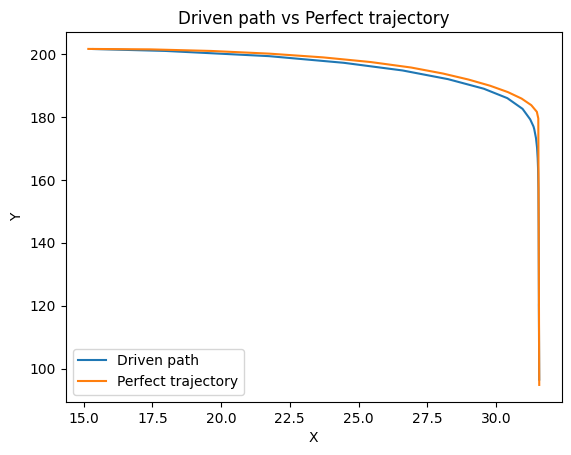

Average velocity: 0.11 m/s
Average acceleration: -0.00 m/s^2
Max acceleration: 2.05 m/s^2
Driven path length: 112.71 meters
Ideal trajectory length: 115.48 meters
DTW: 83.0601340921462
Calculated score: 916.83
There are 5 generated scenarios
3


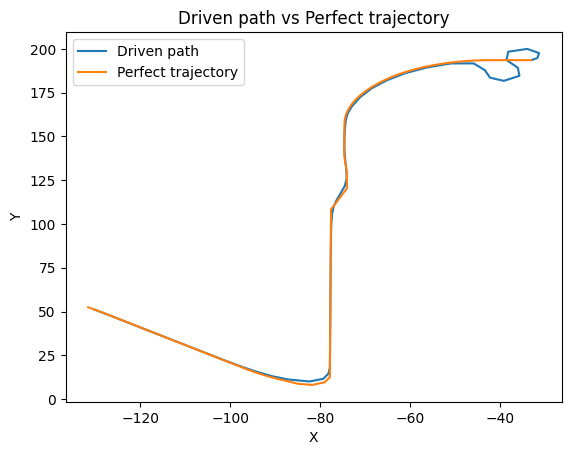

Average velocity: -0.62 m/s
Average acceleration: -0.03 m/s^2
Max acceleration: 3.30 m/s^2
Driven path length: 307.08 meters
Ideal trajectory length: 281.90 meters
DTW: 259.6101940204496
Calculated score: 37.05
There are 5 generated scenarios
2


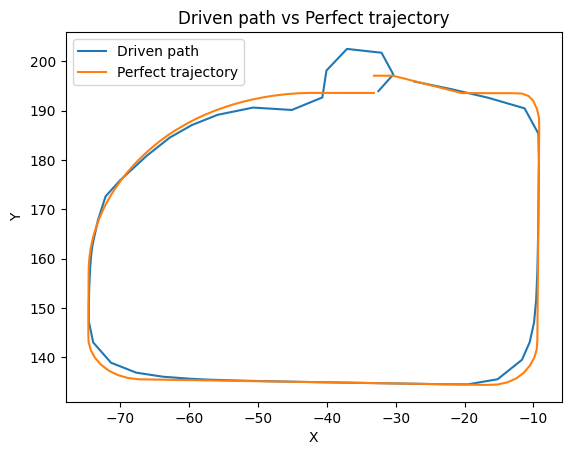

Average velocity: 0.02 m/s
Average acceleration: -0.08 m/s^2
Max acceleration: 2.11 m/s^2
Driven path length: 229.82 meters
Ideal trajectory length: 230.24 meters
DTW: 253.74580315006645
Calculated score: 72.77
There are 5 generated scenarios
0


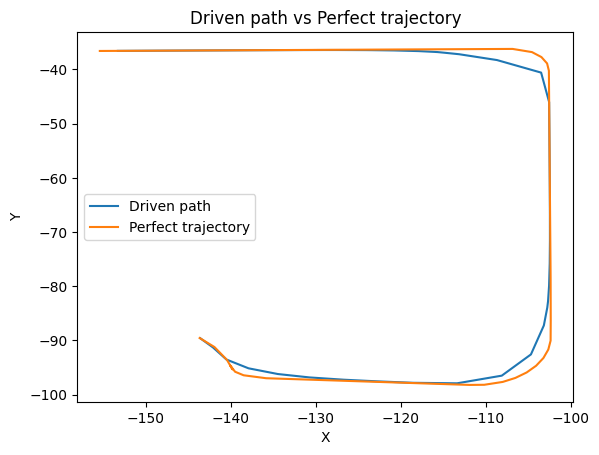

Average velocity: -0.22 m/s
Average acceleration: -0.09 m/s^2
Max acceleration: 1.82 m/s^2
Driven path length: 146.38 meters
Ideal trajectory length: 155.83 meters
DTW: 123.74833401659592
Calculated score: 876.56
There are 5 generated scenarios
4


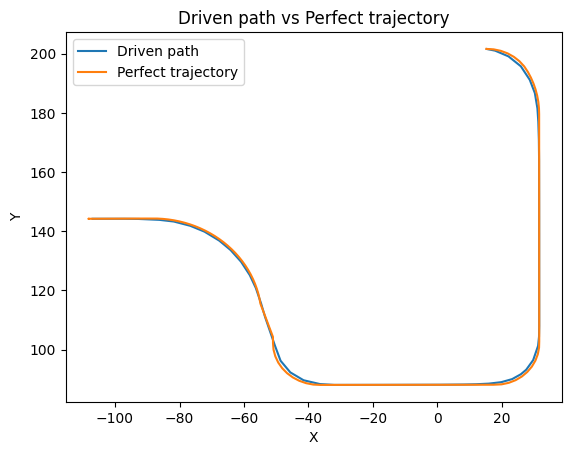

Average velocity: -0.64 m/s
Average acceleration: -0.02 m/s^2
Max acceleration: 2.42 m/s^2
Driven path length: 283.79 meters
Ideal trajectory length: 288.96 meters
DTW: 213.242881422312
Calculated score: 787.42
There are 5 generated scenarios


In [34]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from dtw import *
import math
import json
import matplotlib.pyplot as plt
import numpy as np
import os

rated_objects = []
count = 0
for root, dirs, files in os.walk('user_input/NN_run/step7'):
    for file in files:
        if 'auto_scenario' in file:
        
            
            # Extract the number from the file name
            scenario_num = int(file.split('_')[-1].split('.')[0])
            print(scenario_num)
            # Open the corresponding route file
            with open(f'user_input/NN_run/step5/random_route_{scenario_num}.json', 'r') as f:
                trajectory = json.load(f)

            with open(f'user_input/NN_run/step7/auto_scenario_{scenario_num}.json') as f:
                driven_path_data = json.load(f)

          

            def get_trajectory_length(trajectory):
                # Extract the X and Y coordinates from each location
                x_coords = [location['X'] for location in trajectory]
                y_coords = [location['Y'] for location in trajectory]

                # Compute the Euclidean distances between consecutive points
                distances = [math.sqrt((x2 - x1)**2 + (y2 - y1)**2) for x1, y1, x2, y2 in zip(x_coords[:-1], y_coords[:-1], x_coords[1:], y_coords[1:])]

                # Return the total length of the trajectory
                return sum(distances)

            def path_length(path):
                length = 0
                for i in range(1, len(path)):
                    x1, y1 = path[i-1]
                    x2, y2 = path[i]
                    segment_length = math.sqrt((x2-x1)**2 + (y2-y1)**2)
                    length += segment_length
                return length

    
            driven_path = [(d['vehicle_location']['x'], d['vehicle_location']['y']) for d in driven_path_data]
            
            # Plot the driven path
            plt.plot(*zip(*driven_path), label='Driven path')

            # Extract the X and Y coordinates from each location
            x_coords = [location['X'] for location in trajectory]
            y_coords = [location['Y'] for location in trajectory]

            # Plot the route on a graph
            plt.plot(x_coords, y_coords, label='Perfect trajectory')

            plt.title('Driven path vs Perfect trajectory')
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.legend()
            plt.show()

            # Initialize lists to store data
            timestamps = []
            velocities = []
            throttles = []

            # Extract values from data
            game_time = [entry['game_time'] for entry in driven_path_data]
            velocity = [entry['vehicle_velocity']['x'] for entry in driven_path_data]
            throttle = [entry['vehicle_throttle'] for entry in driven_path_data]

            # Calculate average velocity
            avg_velocity = np.mean(velocity)
            print(f'Average velocity: {avg_velocity:.2f} m/s')

            # Calculate acceleration
            dt = np.mean(np.diff(game_time))
            acceleration = np.gradient(velocity, dt)
            avg_acceleration = np.mean(acceleration)
            print(f'Average acceleration: {avg_acceleration:.2f} m/s^2')
            max_acceleration = max(acceleration)
            print(f'Max acceleration: {max_acceleration:.2f} m/s^2')

            driven_path_length = path_length(driven_path)
            print(f"Driven path length: {driven_path_length:.2f} meters")
            
            ideal_trajectory_length = get_trajectory_length(trajectory)
            print(f"Ideal trajectory length: {ideal_trajectory_length:.2f} meters")


            last_object = driven_path_data[-1]
            num_collisions = last_object["unique_collisions"]
            solid_lane_crosses = last_object["solid_lane_crosses"]
            double_solid_lane_crosses = last_object["double_solid_lane_crosses"]

            # def new_rate_driven_path(trajectory,ideal_trajectory_length, driven_path, driven_path_length, 
            #                          avg_velocity, avg_acceleration, num_collisions, solid_lane_crosses, double_solid_lane_crosses):
            #     # Calculate the DTW distance between the trajectory and driven path
            #     distance, _ = fastdtw(trajectory, driven_path, dist=euclidean)
                
            #     print("DTW: " + str(distance))
            #     print("Collisions: " + str(num_collisions))
            #     print("Solid lane crosses: " + str(solid_lane_crosses))
            #     print("Double solid lane crosses: " + str(double_solid_lane_crosses))
            #     # Set the maximum safety score
            #     max_score = 1000
                
            #     # Calculate the safety score based on distance, velocity, and acceleration
            #     velocity_factor = 1  # Weighting factor for velocity
            #     acceleration_factor = 2  # Weighting factor for acceleration
            #     driven_length_factor = driven_path_length / ideal_trajectory_length  # Scaling factor based on completed length ratio
            #     ideal_trajectory_length_factor = ideal_trajectory_length/10
            #     safety_score = max_score*ideal_trajectory_length_factor*driven_length_factor - distance - velocity_factor * avg_velocity - acceleration_factor * avg_acceleration
            #     # safety_score = max_score*ideal_trajectory_length_factor*driven_length_factor - distance 
                
            #     # Penalize for number of collisions
            #     if num_collisions > 0:
            #         safety_score -= safety_score * (0.95 ** num_collisions)
                
            #     if solid_lane_crosses > 0:
            #         # Penalize for solid lane crosses
            #         solid_lane_cross_penalty = 10
            #         safety_score = safety_score - solid_lane_crosses * solid_lane_cross_penalty
                
            #     if double_solid_lane_crosses > 0:
            #         # Penalize for double solid lane crosses
            #         double_solid_lane_cross_penalty = 30
            #         safety_score = safety_score - double_solid_lane_crosses * double_solid_lane_cross_penalty
                
            #     return safety_score

            def rate_driven_path(trajectory, driven_path, avg_velocity,avg_acceleration,num_collisions):
                # Calculate the DTW distance between the trajectory and driven path
                distance, _ = fastdtw(trajectory, driven_path, dist=euclidean)
                
                print("DTW: "+str(distance))
                # Calculate the safety score based on DTW distance and average velocity
                safety_score = 1000 - distance - avg_velocity -avg_acceleration 
                
                # Penalize for number of collisions
                if num_collisions > 0:
                    safety_score -= safety_score * (0.95**num_collisions)
            
                return safety_score

            # # # Plot velocity over time
            # plt.plot(game_time, velocity)
            # plt.xlabel('Time (s)')
            # plt.ylabel('Velocity (m/s)')
            # plt.show()

            # # Plot acceleration over time
            # plt.plot(game_time, acceleration)
            # plt.xlabel('Time (s)')
            # plt.ylabel('Acceleration (m/s^2)')
            # plt.show()

            perfect_trajectory_array = list(zip(x_coords, y_coords))
            driven_path_array = np.array(driven_path)

            calculated_score = rate_driven_path(perfect_trajectory_array,
                                                    
                                                    driven_path_array,
                                                    
                                                    avg_velocity,
                                                    avg_acceleration,
                                                    num_collisions,
                                                   )
            
            print(f'Calculated score: {calculated_score:.2f}')
           
            # Open the file for reading
            with open('user_input/NN_run/step6/high_score_scenarios.json', 'r') as f:
                data = json.load(f)

            print(f'There are {len(data)} generated scenarios')
            
           
            # Find the object with the desired scenario_num
            for obj in data:
                if obj['scenario_num'] == scenario_num:
                    # Add the new variable
                    obj['calculated_score'] = calculated_score  # Replace 0 with your desired value
                    rated_objects.append(obj)

# Open the file for writing
with open('user_input/NN_run/step8/rated_scenarios.json', 'w') as f:
    json.dump(rated_objects, f,indent=4)
